In [36]:
import copy
import os
import re
import shutil
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import tifffile
import yaml
from einops import rearrange

In [37]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
%autoreload 2

In [39]:
import mushroom.data.multiplex as multiplex
import mushroom.data.visium as visium
import mushroom.data.xenium as xenium
import mushroom.data.cosmx as cosmx
import mushroom.data.he as he
import mushroom.data.user_points as points
import mushroom.registration.bigwarp as bigwarp
import mushroom.utils as utils

In [40]:
project_dir = '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1'
Path(project_dir).mkdir(parents=True, exist_ok=True)

In [41]:
# specifying a channel in multiplex imaging sections to use during registration/visualization
multiplex_channel = 'DAPI'

# scale factors for registration
# each data type identifier will be downsampled by {default_scale}, or scale specified in {dtype_to_scale} (bigwarp registration can be cumbersome with large, full resolution images)
# this scale factor DOES NOT downsample data input to mushroom, mushroom inputs will still be full resolution. It is purely to get bigwarp to run more smoothly.
# here we just downsample every data type by 20%
default_scale = .2

# if you wanted a specific data type to be scaled more or less than other data types, you could specify here
dtype_to_scale = {
#     'multiplex': .1, # for example, if you uncommented this line multiplex data would be scaled by .1 instead of .2
}

## Define inputs

###### HT913Z1

In [25]:
# CODEX
# /diskmnt/primary/CODEX/HTAN/20240812_Prostate_serial_HT913Z1-S2H1FP1-CODEX_1/HT913Z1-S2H1FP1_U2__20240812.ome.tiff
# /diskmnt/primary/CODEX/HTAN/20240812_Prostate_serial_HT913Z1-S2H1FP1-CODEX_1/HT913Z1-S2H1FP1_U12__20240812.ome.tiff
# /diskmnt/primary/CODEX/HTAN/20240812_Prostate_serial_HT913Z1-S2H1FP1-CODEX_1/HT913Z1-S2H1FP1_U22__20240812.ome.tiff
# /diskmnt/primary/CODEX/HTAN/20240812_Prostate_serial_HT913Z1-S2H1FP1-CODEX_1/HT913Z1-S2H1FP1_U41__20240812.ome.tiff
# /diskmnt/primary/CODEX/HTAN/20240812_Prostate_serial_HT913Z1-S2H1FP1-CODEX_2/HT913Z1-S2H1FP1_U51__20240812.ome.tiff
# /diskmnt/primary/CODEX/HTAN/20240812_Prostate_serial_HT913Z1-S2H1FP1-CODEX_2/HT913Z1-S2H1FP1_U52__20240812.ome.tiff
# /diskmnt/primary/CODEX/HTAN/20240812_Prostate_serial_HT913Z1-S2H1FP1-CODEX_2/HT913Z1-S2H1FP1_U53__20240812.ome.tiff
# /diskmnt/primary/CODEX/HTAN/20240812_Prostate_serial_HT913Z1-S2H1FP1-CODEX_2/HT913Z1-S2H1FP1_U54__20240812.ome.tiff
# /diskmnt/primary/CODEX/HTAN/20240812_Prostate_serial_HT913Z1-S2H1FP1-CODEX_3/HT913Z1-S2H1FP1_U62__20240812.ome.tiff
# /diskmnt/primary/CODEX/HTAN/20240812_Prostate_serial_HT913Z1-S2H1FP1-CODEX_3/HT913Z1-S2H1FP1_U71__20240812.ome.tiff
# /diskmnt/primary/CODEX/HTAN/20240812_Prostate_serial_HT913Z1-S2H1FP1-CODEX_3/HT913Z1-S2H1FP1_U82__20240812.ome.tiff
# /diskmnt/primary/CODEX/HTAN/20240812_Prostate_serial_HT913Z1-S2H1FP1-CODEX_3/HT913Z1-S2H1FP1_U91__20240812.ome.tiff
# /diskmnt/primary/CODEX/HTAN/20240812_Prostate_serial_HT913Z1-S2H1FP1-CODEX_4/HT913Z1-S2H1FP1_U102__20240812.ome.tiff
# /diskmnt/primary/CODEX/HTAN/20240812_Prostate_serial_HT913Z1-S2H1FP1-CODEX_4/HT913Z1-S2H1FP1_U111__20240812.ome.tiff
# /diskmnt/primary/CODEX/HTAN/20240812_Prostate_serial_HT913Z1-S2H1FP1-CODEX_4/HT913Z1-S2H1FP1_U121__20240812.ome.tiff
# /diskmnt/primary/CODEX/HTAN/20240812_Prostate_serial_HT913Z1-S2H1FP1-CODEX_4/HT913Z1-S2H1FP1_U125__20240812.ome.tiff

# Xenium
# /diskmnt/primary/Xenium/data/20240710__201651__20240710_5K_Prostate_SenNet/output-XETG00122__0037154__HT913Z1-S2H1Fp1U1__20240710__201813
# /diskmnt/primary/Xenium/data/20240710__201651__20240710_5K_Prostate_SenNet/output-XETG00122__0037154__HT913Z1-S2H1Fp1U11__20240710__201813
# /diskmnt/primary/Xenium/data/20240710__201651__20240710_5K_Prostate_SenNet/output-XETG00122__0037154__HT913Z1-S2H1Fp1U21__20240710__201813
# /diskmnt/primary/Xenium/data/20240703__174409__20240703_HTAN_prostate-serial/output-XETG00122__0024910__HT913Z1-S2H1Fp1U33__20240703__174440
# /diskmnt/primary/Xenium/data/20240703__174409__20240703_HTAN_prostate-serial/output-XETG00122__0024910__HT913Z1-S2H1Fp1U34__20240703__174440
# /diskmnt/primary/Xenium/data/20240703__174409__20240703_HTAN_prostate-serial/output-XETG00122__0024910__HT913Z1-S2H1FpU35__20240703__174440
# /diskmnt/primary/Xenium/data/20240703__174409__20240703_HTAN_prostate-serial/output-XETG00122__0024913__HT913Z1-S2H1Fp1U61__20240703__174440
# /diskmnt/primary/Xenium/data/20240703__174409__20240703_HTAN_prostate-serial/output-XETG00122__0024913__HT913Z1-S2H1Fp1U81__20240703__174440
# /diskmnt/primary/Xenium/data/20240703__174409__20240703_HTAN_prostate-serial/output-XETG00122__0024913__HT913Z1-S2H1Fp1U101__20240703__174440

# HE
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U3.ome.tif
# # /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U4.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U5.ome.tif
# # /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U6.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U7.ome.tif
# # /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U8.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U9.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U10.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U13.ome.tif
# # /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U14.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U15.ome.tif
# # /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U16.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U17.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U19.ome.tif
# # /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U20.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U24.ome.tif
# # /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U25.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U26.ome.tif
# # /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U27.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U28.ome.tif
# # /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U29.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U30.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U36.ome.tif
# # /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U37.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U38.ome.tif
# # /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U39.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U40.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U42.ome.tif
# # /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U43.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U44.ome.tif
# # /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U45.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U46.ome.tif
# # /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U47.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U48.ome.tif
# # /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U49.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U50.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U55.ome.tif
# # /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U56.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U57.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U63.ome.tif
# # /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U64.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U65.ome.tif
# # /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U66.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U67.ome.tif
# # /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U68.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U69.ome.tif
# # /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U70.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U72.ome.tif
# # /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U73.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U74.ome.tif
# # /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U75.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U76.ome.tif
# # /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U77.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U78.ome.tif
# # /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U79.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U80.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U83.ome.tif
# # /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U84.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U85.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U87.ome.tif
# # /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U88.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U89.ome.tif
# # /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U90.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U92.ome.tif
# # /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U93.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U94.ome.tif
# # /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U95.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U96.ome.tif
# # /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U97.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U99.ome.tif
# # /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U100.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U103.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U106.ome.tif
# # /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U107.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U108.ome.tif
# # /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U109.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U110.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U112.ome.tif
# # /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U113.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U115.ome.tif
# # /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U116.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U117.ome.tif
# # /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U118.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U119.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U120.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U122.ome.tif
# # /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U123.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U124.ome.tif
# # /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U139.ome.tif
# # /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U140.ome.tif
# # /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U141.ome.tif
# # /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U142.ome.tif
# # /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U143.ome.tif
# # /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U144.ome.tif
# # /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U145.ome.tif
# # /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U146.ome.tif
# # /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U147.ome.tif
# # /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U148.ome.tif
# # /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U149.ome.tif
# # /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U150.ome.tif

# # 

In [26]:
case = 'HT913Z1'
reg_dir = os.path.join(project_dir, case, 'registration')
Path(reg_dir).mkdir(parents=True, exist_ok=True)

data_map = {
    'target_sid': 'HT913Z1-U1',
    'resolution': None,
    'sections': [
        {
            'sid': 'HT913Z1-U1',
            'position': 5 * 0,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium/data/20240710__201651__20240710_5K_Prostate_SenNet/output-XETG00122__0037154__HT913Z1-S2H1Fp1U1__20240710__201813'
                },
            ] 
        },
        {
            'sid': 'HT913Z1-U2',
            'position': 5 * 1,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20240812_Prostate_serial_HT913Z1-S2H1FP1-CODEX_1/HT913Z1-S2H1FP1_U2__20240812.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'HT913Z1-U3',
            'position': 5 * 2,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U3.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT913Z1-U5',
            'position': 5 * 4,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U5.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT913Z1-U7',
            'position': 5 * 6,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U7.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT913Z1-U9',
            'position': 5 * 8,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U9.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT913Z1-U10',
            'position': 5 * 9,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U10.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT913Z1-U11',
            'position': 5 * 10,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium/data/20240710__201651__20240710_5K_Prostate_SenNet/output-XETG00122__0037154__HT913Z1-S2H1Fp1U11__20240710__201813'
                },
            ] 
        },
        {
            'sid': 'HT913Z1-U12',
            'position': 5 * 11,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20240812_Prostate_serial_HT913Z1-S2H1FP1-CODEX_1/HT913Z1-S2H1FP1_U12__20240812.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'HT913Z1-U13',
            'position': 5 * 12,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U13.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT913Z1-U15',
            'position': 5 * 14,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U15.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT913Z1-U17',
            'position': 5 * 16,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U17.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT913Z1-U19',
            'position': 5 * 18,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U19.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT913Z1-U21',
            'position': 5 * 20,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium/data/20240710__201651__20240710_5K_Prostate_SenNet/output-XETG00122__0037154__HT913Z1-S2H1Fp1U21__20240710__201813'
                },
            ] 
        },
        {
            'sid': 'HT913Z1-U22',
            'position': 5 * 21,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20240812_Prostate_serial_HT913Z1-S2H1FP1-CODEX_1/HT913Z1-S2H1FP1_U22__20240812.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'HT913Z1-U24',
            'position': 5 * 23,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U24.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT913Z1-U26',
            'position': 5 * 25,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U26.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT913Z1-U28',
            'position': 5 * 27,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U28.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT913Z1-U30',
            'position': 5 * 29,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U30.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT913Z1-U33',
            'position': 5 * 32,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium/data/20240703__174409__20240703_HTAN_prostate-serial/output-XETG00122__0024910__HT913Z1-S2H1Fp1U33__20240703__174440'
                },
            ] 
        },
        {
            'sid': 'HT913Z1-U34',
            'position': 5 * 33,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium/data/20240703__174409__20240703_HTAN_prostate-serial/output-XETG00122__0024910__HT913Z1-S2H1Fp1U34__20240703__174440'
                },
            ] 
        },
        {
            'sid': 'HT913Z1-U35',
            'position': 5 * 34,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium/data/20240703__174409__20240703_HTAN_prostate-serial/output-XETG00122__0024910__HT913Z1-S2H1FpU35__20240703__174440'
                },
            ] 
        },
        {
            'sid': 'HT913Z1-U36',
            'position': 5 * 35,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U36.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT913Z1-U38',
            'position': 5 * 37,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U38.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT913Z1-U40',
            'position': 5 * 39,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U40.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT913Z1-U41',
            'position': 5 * 40,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20240812_Prostate_serial_HT913Z1-S2H1FP1-CODEX_1/HT913Z1-S2H1FP1_U41__20240812.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'HT913Z1-U42',
            'position': 5 * 41,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U42.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT913Z1-U44',
            'position': 5 * 43,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U44.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT913Z1-U46',
            'position': 5 * 45,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U46.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT913Z1-U48',
            'position': 5 * 47,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U48.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT913Z1-U50',
            'position': 5 * 49,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U50.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT913Z1-U51',
            'position': 5 * 50,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20240812_Prostate_serial_HT913Z1-S2H1FP1-CODEX_2/HT913Z1-S2H1FP1_U51__20240812.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'HT913Z1-U52',
            'position': 5 * 51,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20240812_Prostate_serial_HT913Z1-S2H1FP1-CODEX_2/HT913Z1-S2H1FP1_U52__20240812.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'HT913Z1-U53',
            'position': 5 * 52,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20240812_Prostate_serial_HT913Z1-S2H1FP1-CODEX_2/HT913Z1-S2H1FP1_U53__20240812.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'HT913Z1-U54',
            'position': 5 * 53,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20240812_Prostate_serial_HT913Z1-S2H1FP1-CODEX_2/HT913Z1-S2H1FP1_U54__20240812.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'HT913Z1-U55',
            'position': 5 * 54,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U55.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT913Z1-U57',
            'position': 5 * 56,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U57.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT913Z1-U61',
            'position': 5 * 60,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium/data/20240703__174409__20240703_HTAN_prostate-serial/output-XETG00122__0024913__HT913Z1-S2H1Fp1U61__20240703__174440'
                },
            ] 
        },
        {
            'sid': 'HT913Z1-U62',
            'position': 5 * 61,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20240812_Prostate_serial_HT913Z1-S2H1FP1-CODEX_3/HT913Z1-S2H1FP1_U62__20240812.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'HT913Z1-U63',
            'position': 5 * 62,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U63.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT913Z1-U65',
            'position': 5 * 64,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U65.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT913Z1-U67',
            'position': 5 * 66,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U67.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT913Z1-U69',
            'position': 5 * 68,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U69.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT913Z1-U71',
            'position': 5 * 70,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20240812_Prostate_serial_HT913Z1-S2H1FP1-CODEX_3/HT913Z1-S2H1FP1_U71__20240812.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'HT913Z1-U72',
            'position': 5 * 71,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U72.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT913Z1-U74',
            'position': 5 * 73,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U74.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT913Z1-U76',
            'position': 5 * 75,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U76.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT913Z1-U78',
            'position': 5 * 77,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U78.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT913Z1-U80',
            'position': 5 * 79,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U80.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT913Z1-U81',
            'position': 5 * 80,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium/data/20240703__174409__20240703_HTAN_prostate-serial/output-XETG00122__0024913__HT913Z1-S2H1Fp1U81__20240703__174440'
                },
            ] 
        },
        {
            'sid': 'HT913Z1-U82',
            'position': 5 * 81,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20240812_Prostate_serial_HT913Z1-S2H1FP1-CODEX_3/HT913Z1-S2H1FP1_U82__20240812.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'HT913Z1-U83',
            'position': 5 * 82,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U83.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT913Z1-U85',
            'position': 5 * 84,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U85.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT913Z1-U87',
            'position': 5 * 86,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U87.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT913Z1-U89',
            'position': 5 * 88,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U89.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT913Z1-U91',
            'position': 5 * 90,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20240812_Prostate_serial_HT913Z1-S2H1FP1-CODEX_3/HT913Z1-S2H1FP1_U91__20240812.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'HT913Z1-U92',
            'position': 5 * 91,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U92.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT913Z1-U94',
            'position': 5 * 93,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U94.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT913Z1-U96',
            'position': 5 * 95,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U96.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT913Z1-U99',
            'position': 5 * 98,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U99.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT913Z1-U101',
            'position': 5 * 100,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium/data/20240703__174409__20240703_HTAN_prostate-serial/output-XETG00122__0024913__HT913Z1-S2H1Fp1U101__20240703__174440'
                },
            ] 
        },
        {
            'sid': 'HT913Z1-U102',
            'position': 5 * 101,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20240812_Prostate_serial_HT913Z1-S2H1FP1-CODEX_4/HT913Z1-S2H1FP1_U102__20240812.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'HT913Z1-U103',
            'position': 5 * 102,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U103.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT913Z1-U106',
            'position': 5 * 105,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U106.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT913Z1-U108',
            'position': 5 * 107,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U108.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT913Z1-U110',
            'position': 5 * 109,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U110.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT913Z1-U111',
            'position': 5 * 110,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20240812_Prostate_serial_HT913Z1-S2H1FP1-CODEX_4/HT913Z1-S2H1FP1_U111__20240812.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'HT913Z1-U112',
            'position': 5 * 111,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U112.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT913Z1-U115',
            'position': 5 * 114,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U115.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT913Z1-U117',
            'position': 5 * 116,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U117.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT913Z1-U119',
            'position': 5 * 118,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U119.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT913Z1-U120',
            'position': 5 * 119,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U120.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT913Z1-U121',
            'position': 5 * 120,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20240812_Prostate_serial_HT913Z1-S2H1FP1-CODEX_4/HT913Z1-S2H1FP1_U121__20240812.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'HT913Z1-U122',
            'position': 5 * 121,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U122.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT913Z1-U124',
            'position': 5 * 123,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT913Z1/HT913Z1_U124.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT913Z1-U125',
            'position': 5 * 124,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20240812_Prostate_serial_HT913Z1-S2H1FP1-CODEX_4/HT913Z1-S2H1FP1_U125__20240812.ome.tiff'
                },
            ] 
        },
    ]
}

In [28]:
yaml.safe_dump(data_map, open('/diskmnt/Projects/Users/estorrs/sandbox/HT913Z1_sections.yaml', 'w'))

###### HT891Z1

In [7]:
# Xenium
# /diskmnt/primary/Xenium/data/20240524__182517__20240524_HTAN_prostate_serial/output-XETG00122__0034184__HT891Z1-S2H3Fp1U1__20240524__182554
# /diskmnt/primary/Xenium/data/20240524__182517__20240524_HTAN_prostate_serial/output-XETG00122__0034184__HT891Z1-S2H3Fp1U21__20240524__182554
# /diskmnt/primary/Xenium/data/20240524__182517__20240524_HTAN_prostate_serial/output-XETG00122__0034184__HT891Z1-S2H3Fp1U31__20240524__182554
# /diskmnt/primary/Xenium/data/20240524__182517__20240524_HTAN_prostate_serial/output-XETG00122__0034183__HT891Z1-S2H3Fp1U44__20240524__182554
# /diskmnt/primary/Xenium/data/20240524__182517__20240524_HTAN_prostate_serial/output-XETG00122__0034183__HT891Z1-S2H3Fp1U59__20240524__182554
# /diskmnt/primary/Xenium/data/20240524__182517__20240524_HTAN_prostate_serial/output-XETG00122__0034183__HT891Z1-S2H3Fp1U69__20240524__182554
# /diskmnt/primary/Xenium/data/20240613__175032__20240613_Prostate_SNP/output-XETG00122__0033823__HT891Z1-S2H3Fp1U81__20240613__175113
# /diskmnt/primary/Xenium/data/20240613__175032__20240613_Prostate_SNP/output-XETG00122__0033823__HT891Z1-S2H3Fp1U94__20240613__175113 
# /diskmnt/primary/Xenium/data/20240613__175032__20240613_Prostate_SNP/output-XETG00122__0033823__HT891Z1-S2H3Fp1U104__20240613__175113

# CODEX
# /diskmnt/primary/CODEX/HTAN/20240723_Prostate_serial_HT891Z1-S2H3Fp1_Codex1/HT891Z1-S2H3Fp1_U14__20240723.ome.tiff
# /diskmnt/primary/CODEX/HTAN/20240723_Prostate_serial_HT891Z1-S2H3Fp1_Codex1/HT891Z1-S2H3Fp1_U31__20240723.ome.tiff
# /diskmnt/primary/CODEX/HTAN/20240723_Prostate_serial_HT891Z1-S2H3Fp1_Codex1/HT891Z1-S2H3Fp1_U43__20240723.ome.tiff
# /diskmnt/primary/CODEX/HTAN/20240723_Prostate_serial_HT891Z1-S2H3Fp1_Codex1/HT891Z1-S2H3Fp1_U58__20240723.ome.tiff
# /diskmnt/primary/CODEX/HTAN/20240723_Prostate_serial_HT891Z1-S2H3Fp1_Codex1/HT891Z1-S2H3Fp1_U79__20240723.ome.tiff
# /diskmnt/primary/CODEX/HTAN/20240723_Prostate_serial_HT891Z1-S2H3Fp1_Codex1/HT891Z1-S2H3Fp1_U93__20240723.ome.tiff
# /diskmnt/primary/CODEX/HTAN/20240723_Prostate_serial_HT891Z1-S2H3Fp1_Codex1/HT891Z1-S2H3Fp1_U103__20240723.ome.tiff
# /diskmnt/primary/CODEX/HTAN/20240723_Prostate_serial_HT891Z1-S2H3Fp1_Codex1/HT891Z1-S2H3Fp1_U113__20240723.ome.tiff
# /diskmnt/primary/CODEX/HTAN/20240720_Prostate_serial_HT891Z1-S2H3Fp1-HE-6/HT891Z1-S2H3Fp1_U40__20240720.ome.tiff
# /diskmnt/primary/CODEX/HTAN/20240720_Prostate_serial_HT891Z1-S2H3Fp1-HE-6/HT891Z1-S2H3Fp1_U41__20240720.ome.tiff
# /diskmnt/primary/CODEX/HTAN/20240720_Prostate_serial_HT891Z1-S2H3Fp1-HE-6/HT891Z1-S2H3Fp1_U45__20240720.ome.tiff
# /diskmnt/primary/CODEX/HTAN/20240720_Prostate_serial_HT891Z1-S2H3Fp1-HE-6/HT891Z1-S2H3Fp1_U46__20240720.ome.tiff
# /diskmnt/primary/CODEX/HTAN/20240720_Prostate_serial_HT891Z1-S2H3Fp1-HE-6/HT891Z1-S2H3Fp1_U108__20240720.ome.tiff
# /diskmnt/primary/CODEX/HTAN/20240720_Prostate_serial_HT891Z1-S2H3Fp1-HE-6/HT891Z1-S2H3Fp1_U109__20240720.ome.tiff
# /diskmnt/primary/CODEX/HTAN/20240720_Prostate_serial_HT891Z1-S2H3Fp1-HE-6/HT891Z1-S2H3Fp1_U110__20240720.ome.tiff
# /diskmnt/primary/CODEX/HTAN/20240720_Prostate_serial_HT891Z1-S2H3Fp1-HE-6/HT891Z1-S2H3Fp1_U111__20240720.ome.tiff

# HE
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT891Z1/HT891Z1-S2H3FP1_U4.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT891Z1/HT891Z1-S2H3FP1_U5.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT891Z1/HT891Z1-S2H3FP1_U6.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT891Z1/HT891Z1-S2H3FP1_U7.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT891Z1/HT891Z1-S2H3FP1_U28.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT891Z1/HT891Z1-S2H3FP1_U29.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT891Z1/HT891Z1-S2H3FP1_U30.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT891Z1/HT891Z1-S2H3FP1_U35.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT891Z1/HT891Z1-S2H3FP1_U47.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT891Z1/HT891Z1-S2H3FP1_U48.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT891Z1/HT891Z1-S2H3FP1_U49.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT891Z1/HT891Z1-S2H3FP1_U50.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT891Z1/HT891Z1-S2H3FP1_U66.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT891Z1/HT891Z1-S2H3FP1_U68.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT891Z1/HT891Z1-S2H3FP1_U70.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT891Z1/HT891Z1-S2H3FP1_U84.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT891Z1/HT891Z1-S2H3FP1_U85.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT891Z1/HT891Z1-S2H3FP1_U89.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT891Z1/HT891Z1-S2H3FP1_U90.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT891Z1/HT891Z1-S2H3FP1_U101.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT891Z1/HT891Z1-S2H3FP1_U102.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT891Z1/HT891Z1-S2H3FP1_U106.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT891Z1/HT891Z1-S2H3FP1_U107.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT891Z1/HT891Z1-S2H3FP1_U114.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT891Z1/HT891Z1-S2H3FP1_U115.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT891Z1/HT891Z1-S2H3FP1_U116.ome.tif

# VISIUM HD
# /diskmnt/primary/Spatial_Transcriptomics/VisiumHD_run/FFPE/SpacerangerOut/HTAN/PCa/HT891Z1-S2H3Fp1/HT891Z1-S2H3Fp1U2
# /diskmnt/primary/Spatial_Transcriptomics/VisiumHD_run/FFPE/SpacerangerOut/HTAN/PCa/HT891Z1-S2H3Fp1/

NameError: name 'diskmnt' is not defined

In [8]:
case = 'HT891Z1'
reg_dir = os.path.join(project_dir, case, 'registration')
Path(reg_dir).mkdir(parents=True, exist_ok=True)

data_map = {
    'target_sid': 'HT891Z1-U1',
    'resolution': None,
    'sections': [
        {
            'sid': 'HT891Z1-U1',
            'position': 5 * 0,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium/data/20240524__182517__20240524_HTAN_prostate_serial/output-XETG00122__0034184__HT891Z1-S2H3Fp1U1__20240524__182554'
                },
            ] 
        },
        {
            'sid': 'HT891Z1-U4',
            'position': 5 * 2, # this is actually in front 
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT891Z1/HT891Z1-S2H3FP1_U4.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT891Z1-U5',
            'position': 5 * 4,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT891Z1/HT891Z1-S2H3FP1_U5.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT891Z1-U6',
            'position': 5 * 5,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT891Z1/HT891Z1-S2H3FP1_U6.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT891Z1-U7',
            'position': 5 * 6,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT891Z1/HT891Z1-S2H3FP1_U7.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT891Z1-U14',
            'position': 5 * 13,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20240723_Prostate_serial_HT891Z1-S2H3Fp1_Codex1/HT891Z1-S2H3Fp1_U14__20240723.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'HT891Z1-U21',
            'position': 5 * 20,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium/data/20240524__182517__20240524_HTAN_prostate_serial/output-XETG00122__0034184__HT891Z1-S2H3Fp1U21__20240524__182554'
                },
            ] 
        },
        {
            'sid': 'HT891Z1-U28',
            'position': 5 * 27,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT891Z1/HT891Z1-S2H3FP1_U28.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT891Z1-U29',
            'position': 5 * 28,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT891Z1/HT891Z1-S2H3FP1_U29.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT891Z1-U30',
            'position': 5 * 29,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT891Z1/HT891Z1-S2H3FP1_U30.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT891Z1-U31',
            'position': 5 * 30,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium/data/20240524__182517__20240524_HTAN_prostate_serial/output-XETG00122__0034184__HT891Z1-S2H3Fp1U31__20240524__182554'
                },
            ] 
        },
        {
            'sid': 'HT891Z1-U32',
            'position': 5 * 31,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20240723_Prostate_serial_HT891Z1-S2H3Fp1_Codex1/HT891Z1-S2H3Fp1_U31__20240723.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'HT891Z1-U35',
            'position': 5 * 34,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT891Z1/HT891Z1-S2H3FP1_U35.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT891Z1-U40',
            'position': 5 * 39,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20240720_Prostate_serial_HT891Z1-S2H3Fp1-HE-6/HT891Z1-S2H3Fp1_U40__20240720.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'HT891Z1-U41',
            'position': 5 * 40,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20240720_Prostate_serial_HT891Z1-S2H3Fp1-HE-6/HT891Z1-S2H3Fp1_U41__20240720.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'HT891Z1-U43',
            'position': 5 * 42,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20240723_Prostate_serial_HT891Z1-S2H3Fp1_Codex1/HT891Z1-S2H3Fp1_U43__20240723.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'HT891Z1-U44',
            'position': 5 * 43,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium/data/20240524__182517__20240524_HTAN_prostate_serial/output-XETG00122__0034183__HT891Z1-S2H3Fp1U44__20240524__182554'
                },
            ] 
        },
        {
            'sid': 'HT891Z1-U45',
            'position': 5 * 44,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20240720_Prostate_serial_HT891Z1-S2H3Fp1-HE-6/HT891Z1-S2H3Fp1_U45__20240720.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'HT891Z1-U46',
            'position': 5 * 45,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20240720_Prostate_serial_HT891Z1-S2H3Fp1-HE-6/HT891Z1-S2H3Fp1_U46__20240720.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'HT891Z1-U47',
            'position': 5 * 46,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT891Z1/HT891Z1-S2H3FP1_U47.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT891Z1-U48',
            'position': 5 * 47,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT891Z1/HT891Z1-S2H3FP1_U48.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT891Z1-U49',
            'position': 5 * 48,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT891Z1/HT891Z1-S2H3FP1_U49.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT891Z1-U50',
            'position': 5 * 49,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT891Z1/HT891Z1-S2H3FP1_U50.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT891Z1-U58',
            'position': 5 * 57,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20240723_Prostate_serial_HT891Z1-S2H3Fp1_Codex1/HT891Z1-S2H3Fp1_U58__20240723.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'HT891Z1-U59',
            'position': 5 * 58,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium/data/20240524__182517__20240524_HTAN_prostate_serial/output-XETG00122__0034183__HT891Z1-S2H3Fp1U59__20240524__182554'
                },
            ] 
        },
        {
            'sid': 'HT891Z1-U66',
            'position': 5 * 65,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT891Z1/HT891Z1-S2H3FP1_U66.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT891Z1-U68',
            'position': 5 * 67,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT891Z1/HT891Z1-S2H3FP1_U68.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT891Z1-U69',
            'position': 5 * 68,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium/data/20240524__182517__20240524_HTAN_prostate_serial/output-XETG00122__0034183__HT891Z1-S2H3Fp1U69__20240524__182554'
                },
            ] 
        },
        {
            'sid': 'HT891Z1-U70',
            'position': 5 * 69,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT891Z1/HT891Z1-S2H3FP1_U70.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT891Z1-U79',
            'position': 5 * 78,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20240723_Prostate_serial_HT891Z1-S2H3Fp1_Codex1/HT891Z1-S2H3Fp1_U79__20240723.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'HT891Z1-U81',
            'position': 5 * 80,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium/data/20240613__175032__20240613_Prostate_SNP/output-XETG00122__0033823__HT891Z1-S2H3Fp1U81__20240613__175113'
                },
            ] 
        },
        {
            'sid': 'HT891Z1-U84',
            'position': 5 * 83,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT891Z1/HT891Z1-S2H3FP1_U84.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT891Z1-U89',
            'position': 5 * 88,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT891Z1/HT891Z1-S2H3FP1_U89.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT891Z1-U90',
            'position': 5 * 89,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT891Z1/HT891Z1-S2H3FP1_U90.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT891Z1-U93',
            'position': 5 * 92,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20240723_Prostate_serial_HT891Z1-S2H3Fp1_Codex1/HT891Z1-S2H3Fp1_U93__20240723.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'HT891Z1-U94',
            'position': 5 * 93,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium/data/20240613__175032__20240613_Prostate_SNP/output-XETG00122__0033823__HT891Z1-S2H3Fp1U94__20240613__175113'
                },
            ] 
        },
        {
            'sid': 'HT891Z1-U101',
            'position': 5 * 100,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT891Z1/HT891Z1-S2H3FP1_U101.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT891Z1-U102',
            'position': 5 * 101,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT891Z1/HT891Z1-S2H3FP1_U102.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT891Z1-U103',
            'position': 5 * 102,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20240723_Prostate_serial_HT891Z1-S2H3Fp1_Codex1/HT891Z1-S2H3Fp1_U103__20240723.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'HT891Z1-U104',
            'position': 5 * 103,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium/data/20240613__175032__20240613_Prostate_SNP/output-XETG00122__0033823__HT891Z1-S2H3Fp1U104__20240613__175113'
                },
            ] 
        },
        {
            'sid': 'HT891Z1-U106',
            'position': 5 * 105,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT891Z1/HT891Z1-S2H3FP1_U106.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT891Z1-U107',
            'position': 5 * 106,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT891Z1/HT891Z1-S2H3FP1_U107.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT891Z1-U108',
            'position': 5 * 107,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20240720_Prostate_serial_HT891Z1-S2H3Fp1-HE-6/HT891Z1-S2H3Fp1_U108__20240720.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'HT891Z1-U109',
            'position': 5 * 108,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20240720_Prostate_serial_HT891Z1-S2H3Fp1-HE-6/HT891Z1-S2H3Fp1_U109__20240720.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'HT891Z1-U110',
            'position': 5 * 109,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20240720_Prostate_serial_HT891Z1-S2H3Fp1-HE-6/HT891Z1-S2H3Fp1_U110__20240720.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'HT891Z1-U111',
            'position': 5 * 110,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20240720_Prostate_serial_HT891Z1-S2H3Fp1-HE-6/HT891Z1-S2H3Fp1_U111__20240720.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'HT891Z1-U113',
            'position': 5 * 112,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20240723_Prostate_serial_HT891Z1-S2H3Fp1_Codex1/HT891Z1-S2H3Fp1_U113__20240723.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'HT891Z1-U114',
            'position': 5 * 113,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT891Z1/HT891Z1-S2H3FP1_U114.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT891Z1-U115',
            'position': 5 * 114,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT891Z1/HT891Z1-S2H3FP1_U115.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT891Z1-U116',
            'position': 5 * 115,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT891Z1/HT891Z1-S2H3FP1_U116.ome.tif'
                },
            ] 
        },
    ]
}

In [25]:
a = xenium.adata_from_xenium(
    '/diskmnt/primary/Xenium/data/20240613__175032__20240613_Prostate_SNP/output-XETG00122__0033823__HT891Z1-S2H3Fp1U94__20240613__175113'
)
a

/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
<tifffile.TiffFile 'morphology_focus_0000.ome.tif'> OME series cannot read multi-file pyramids


AnnData object with n_obs × n_vars = 160268 × 476
    obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial', 'ppm'
    obsm: 'spatial'

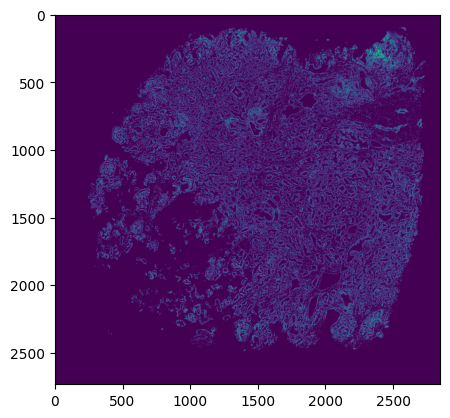

In [30]:
import matplotlib.pyplot as plt
plt.imshow(img)

In [31]:
# image_data = next(iter(a.uns['spatial'].values()))
    
# img = image_data['images']['hires'] # grab image

# # # need to adjust scale by tissue_hires_scalef because spot/cell coordinates are at a different resolution than the image
# # sf = scale / image_data['scalefactors']['tissue_hires_scalef']

# # dim_order = 'h w' if dtype in ['xenium', 'cosmx'] else 'h w c'
# # img = utils.rescale(img, scale=sf, dim_order=dim_order, target_dtype=np.uint8) # scale image    

###### HT704B1

In [7]:
# CODEX
# /diskmnt/primary/CODEX/HTAN/20240705_Human_BRCA_HT704B1_CODEX_5/HT704B1_U76__20240705.ome.tiff
# /diskmnt/primary/CODEX/HTAN/20240705_Human_BRCA_HT704B1_CODEX_5/HT704B1_U82__20240705.ome.tiff
# /diskmnt/primary/CODEX/HTAN/20240705_Human_BRCA_HT704B1_CODEX_5/HT704B1_U85__20240705.ome.tiff
# /diskmnt/primary/CODEX/HTAN/20240705_Human_BRCA_HT704B1_CODEX_5/HT704B1_U91__20240705.ome.tiff
# /diskmnt/primary/CODEX/HTAN/20240705_Human_BRCA_HT704B1_CODEX_3/HT704B1_U43__20240705.ome.tiff
# /diskmnt/primary/CODEX/HTAN/20240705_Human_BRCA_HT704B1_CODEX_3/HT704B1_U53__20240705.ome.tiff
# /diskmnt/primary/CODEX/HTAN/20240705_Human_BRCA_HT704B1_CODEX_3/HT704B1_U60__20240705.ome.tiff
# /diskmnt/primary/CODEX/HTAN/20240705_Human_BRCA_HT704B1_CODEX_3/HT704B1_U68__20240705.ome.tiff
# /diskmnt/primary/CODEX/HTAN/20240705_Human_BRCA_HT704B1_CODEX_1/HT704B1_U11__20240705.ome.tiff
# /diskmnt/primary/CODEX/HTAN/20240705_Human_BRCA_HT704B1_CODEX_1/HT704B1_U19__20240705.ome.tiff
# /diskmnt/primary/CODEX/HTAN/20240705_Human_BRCA_HT704B1_CODEX_1/HT704B1_U27__20240705.ome.tiff
# /diskmnt/primary/CODEX/HTAN/20240705_Human_BRCA_HT704B1_CODEX_1/HT704B1_U35__20240705.ome.tiff

# Cosmx
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/cosmx/HT704B1/HT704B1-S1H3Fp1U14.h5ad
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/cosmx/HT704B1/HT704B1-S1H3Fp1U22.h5ad
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/cosmx/HT704B1/HT704B1-S1H3Fp1U47.h5ad
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/cosmx/HT704B1/HT704B1-S1H3Fp1U56.h5ad

# Xenium
# /diskmnt/primary/Xenium/data/20240619__174946__20240619_HTAN_BRCA-serial/output-XETG00122__0034390__HT704B1-S1H3Fp1U1__20240619__175030
# /diskmnt/primary/Xenium/data/20240619__174946__20240619_HTAN_BRCA-serial/output-XETG00122__0034390__HT704B1-S1H3Fp1U17__20240619__175030
# /diskmnt/primary/Xenium/data/20240619__174946__20240619_HTAN_BRCA-serial/output-XETG00122__0034390__HT704B1-S1H3Fp1U26__20240619__175030
# /diskmnt/primary/Xenium/data/20240619__174946__20240619_HTAN_BRCA-serial/output-XETG00122__0034322__HT704B1-S1H3Fp1U33__20240619__175030
# /diskmnt/primary/Xenium/data/20240619__174946__20240619_HTAN_BRCA-serial/output-XETG00122__0034322__HT704B1-SH3Fp1U41__20240619__175031
# /diskmnt/primary/Xenium/data/20240619__174946__20240619_HTAN_BRCA-serial/output-XETG00122__0034322__HT704B1-S1H3Fp1U50__20240619__175031


# H&E
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT704B1/HT704B1_U12.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT704B1/HT704B1_U15.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT704B1/HT704B1_U20.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT704B1/HT704B1_U23.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT704B1/HT704B1_U28.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT704B1/HT704B1_U31.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT704B1/HT704B1_U36.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT704B1/HT704B1_U39.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT704B1/HT704B1_U44.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT704B1/HT704B1_U48.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT704B1/HT704B1_U54.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT704B1/HT704B1_U57.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT704B1/HT704B1_U61.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT704B1/HT704B1_U65.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT704B1/HT704B1_U69.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT704B1/HT704B1_U73.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT704B1/HT704B1_U81.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT704B1/HT704B1_U84.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT704B1/HT704B1_U90.ome.tif
# /diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT704B1/HT704B1_U93.ome.tif


In [42]:
case = 'HT704B1'
reg_dir = os.path.join(project_dir, case, 'registration')
Path(reg_dir).mkdir(parents=True, exist_ok=True)

data_map = {
    'target_sid': 'HT704B1-U1',
    'resolution': None,
    'sections': [
        {
            'sid': 'HT704B1-U1',
            'position': 0,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium/data/20240619__174946__20240619_HTAN_BRCA-serial/output-XETG00122__0034390__HT704B1-S1H3Fp1U1__20240619__175030'
                },
            ] 
        },
        {
            'sid': 'HT704B1-U11',
            'position': 50,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20240705_Human_BRCA_HT704B1_CODEX_1/HT704B1_U11__20240705.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'HT704B1-U12',
            'position': 5 * 11,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT704B1/HT704B1_U12.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT704B1-U14',
            'position': 13 * 5,
            'data': [
                {
                    'dtype': 'cosmx',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/cosmx/HT704B1/HT704B1-S1H3Fp1U14.h5ad'
                },
            ] 
        },
        {
            'sid': 'HT704B1-U15',
            'position': 5 * 14,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT704B1/HT704B1_U15.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT704B1-U17',
            'position': 80,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium/data/20240619__174946__20240619_HTAN_BRCA-serial/output-XETG00122__0034390__HT704B1-S1H3Fp1U17__20240619__175030'
                },
            ] 
        },
        {
            'sid': 'HT704B1-U19',
            'position': 18 * 5,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20240705_Human_BRCA_HT704B1_CODEX_1/HT704B1_U19__20240705.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'HT704B1-U20',
            'position': 5 * 19,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT704B1/HT704B1_U20.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT704B1-U22',
            'position': 21 * 5,
            'data': [
                {
                    'dtype': 'cosmx',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/cosmx/HT704B1/HT704B1-S1H3Fp1U22.h5ad'
                },
            ] 
        },
        {
            'sid': 'HT704B1-U23',
            'position': 5 * 22,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT704B1/HT704B1_U23.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT704B1-U26',
            'position': 125,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium/data/20240619__174946__20240619_HTAN_BRCA-serial/output-XETG00122__0034390__HT704B1-S1H3Fp1U26__20240619__175030'
                },
            ] 
        },
        {
            'sid': 'HT704B1-U27',
            'position': 26 * 5,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20240705_Human_BRCA_HT704B1_CODEX_1/HT704B1_U27__20240705.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'HT704B1-U28',
            'position': 5 * 27,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT704B1/HT704B1_U28.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT704B1-U31',
            'position': 5 * 30,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT704B1/HT704B1_U31.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT704B1-U33',
            'position': 160,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium/data/20240619__174946__20240619_HTAN_BRCA-serial/output-XETG00122__0034322__HT704B1-S1H3Fp1U33__20240619__175030'
                },
            ] 
        },
        {
            'sid': 'HT704B1-U35',
            'position': 34 * 5,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20240705_Human_BRCA_HT704B1_CODEX_1/HT704B1_U35__20240705.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'HT704B1-U36',
            'position': 5 * 35,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT704B1/HT704B1_U36.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT704B1-U39',
            'position': 5 * 38,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT704B1/HT704B1_U39.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT704B1-U41',
            'position': 200,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium/data/20240619__174946__20240619_HTAN_BRCA-serial/output-XETG00122__0034322__HT704B1-SH3Fp1U41__20240619__175031'
                },
            ] 
        },
        {
            'sid': 'HT704B1-U43',
            'position': 42 * 5,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20240705_Human_BRCA_HT704B1_CODEX_3/HT704B1_U43__20240705.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'HT704B1-U44',
            'position': 5 * 43,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT704B1/HT704B1_U44.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT704B1-U47',
            'position': 5 * 46,
            'data': [
                {
                    'dtype': 'cosmx',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/cosmx/HT704B1/HT704B1-S1H3Fp1U47.h5ad'
                },
            ] 
        },
        {
            'sid': 'HT704B1-U48',
            'position': 5 * 47,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT704B1/HT704B1_U48.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT704B1-U50',
            'position': 245,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium/data/20240619__174946__20240619_HTAN_BRCA-serial/output-XETG00122__0034322__HT704B1-S1H3Fp1U50__20240619__175031'
                },
            ] 
        },
        {
            'sid': 'HT704B1-U53',
            'position': 52 * 5,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20240705_Human_BRCA_HT704B1_CODEX_3/HT704B1_U53__20240705.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'HT704B1-U54',
            'position': 5 * 53,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT704B1/HT704B1_U54.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT704B1-U56',
            'position': 5 * 55,
            'data': [
                {
                    'dtype': 'cosmx',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/cosmx/HT704B1/HT704B1-S1H3Fp1U56.h5ad'
                },
            ] 
        },
        {
            'sid': 'HT704B1-U57',
            'position': 5 * 56,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT704B1/HT704B1_U57.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT704B1-U60',
            'position': 59 * 5,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20240705_Human_BRCA_HT704B1_CODEX_3/HT704B1_U60__20240705.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'HT704B1-U61',
            'position': 5 * 60,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT704B1/HT704B1_U61.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT704B1-U65',
            'position': 5 * 64,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT704B1/HT704B1_U65.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT704B1-U68',
            'position': 67 * 5,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20240705_Human_BRCA_HT704B1_CODEX_3/HT704B1_U68__20240705.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'HT704B1-U69',
            'position': 5 * 68,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT704B1/HT704B1_U69.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT704B1-U73',
            'position': 5 * 72,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT704B1/HT704B1_U73.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT704B1-U76',
            'position': 75 * 5,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20240705_Human_BRCA_HT704B1_CODEX_5/HT704B1_U76__20240705.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'HT704B1-U81',
            'position': 5 * 80,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT704B1/HT704B1_U81.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT704B1-U82',
            'position': 81 * 5,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20240705_Human_BRCA_HT704B1_CODEX_5/HT704B1_U82__20240705.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'HT704B1-U84',
            'position': 5 * 83,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT704B1/HT704B1_U84.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT704B1-U85',
            'position': 84 * 5,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20240705_Human_BRCA_HT704B1_CODEX_5/HT704B1_U85__20240705.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'HT704B1-U90',
            'position': 5 * 91,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT704B1/HT704B1_U90.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT704B1-U91',
            'position': 90 * 5,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20240705_Human_BRCA_HT704B1_CODEX_5/HT704B1_U91__20240705.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'HT704B1-U93',
            'position': 5 * 92,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT704B1/HT704B1_U93.ome.tif'
                },
            ] 
        },
    ]
}


In [47]:
# for entry in data_map['sections']:
#     print(entry['sid'], entry['position'] // 5 * 2, entry['data'][0]['dtype'])

###### S18-9906

In [26]:
case = 'S18-9906'
reg_dir = os.path.join(project_dir, case, 'registration')
Path(project_dir).mkdir(parents=True, exist_ok=True)

data_map = {
    'target_sid': 'S18-9906-U2',
    'resolution': None,
    'sections': [
        {
            'sid': 'S18-9906-U1',
            'position': 0,
            'data': [
                {
                    'dtype': 'visium',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/outputs_FFPE/Human/S18-9906/B27/S18-9906-B27Us1_1Bp1/outs'
                },
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/images/all/A1_S18-9906-B27Us1_1.tif'
                },
            ] 
        },
        {
            'sid': 'S18-9906-U2',
            'position': 5,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium/data/20230912__220334__24002/output-XETG00122__0010784__S18-9906-B27Us1_2Q1__20230912__220421'
                },
            ] 
        },
        {
            'sid': 'S18-9906-U3',
            'position': 10,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20231006_Prostate_Serial_S18-9906_slide_3/S18-9906-U3__20231006.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'S18-9906-U5',
            'position': 20,
            'data': [
                {
                    'dtype': 'batch2_he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/S18-9906/S18-9906-B27U5.tif'
                },
            ] 
        },
        {
            'sid': 'S18-9906-U9',
            'position': 40,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium/data/20230912__220334__24002/output-XETG00122__0010787__S18-9906-B27Us1_9Q1__20230912__220421'
                },
            ] 
        },
        {
            'sid': 'S18-9906-U10',
            'position': 45,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20231006_Prostate_Serial_S18-9906_slide_3/S18-9906-U10__20231006.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'S18-9906-U12',
            'position': 55,
            'data': [
                {
                    'dtype': 'batch2_he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/S18-9906/S18-9906-B27U12.tif'
                },
            ] 
        },
        {
            'sid': 'S18-9906-U16',
            'position': 105,
            'data': [
                {
                    'dtype': 'visium',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/outputs_FFPE/Human/S18-9906/B27/S18-9906-B27Us1_16Bp1/outs'
                },
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/images/all/B1_S18-9906-B27Us1_16.tif'
                },
            ] 
        },
        {
            'sid': 'S18-9906-U17',
            'position': 120,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium/data/20230912__220334__24002/output-XETG00122__0010784__S18-9906-B27Us1_17Q1__20230912__220421'
                },
            ] 
        },
        {
            'sid': 'S18-9906-U18',
            'position': 125,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20231006_Prostate_Serial_S18-9906_slide_3/S18-9906-U18__20231006.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'S18-9906-U20',
            'position': 135,
            'data': [
                {
                    'dtype': 'batch2_he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/S18-9906/S18-9906-B27U20.tif'
                },
            ] 
        },
        {
            'sid': 'S18-9906-U24',
            'position': 155,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium/data/20230912__220334__24002/output-XETG00122__0010787__S18-9906-B27Us1_24Q1__20230912__220421'
                },
            ] 
        },
        {
            'sid': 'S18-9906-U25',
            'position': 160,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20231006_Prostate_Serial_S18-9906_slide_3/S18-9906-U25__20231006.ome.tiff'
                }
            ]
        }
    ]
}


###### HT397B1

In [14]:
case = 'HT397B1'
reg_dir = os.path.join(project_dir, case, 'registration')
Path(project_dir).mkdir(parents=True, exist_ok=True)

## fuzzy positions
data_map = {
    'target_sid': 'HT397B1-U1',
    'resolution': None,
    'sections': [
        {
            'sid': 'HT397B1-U1',
            'position': 0,
            'data': [
                {
                    'dtype': 'visium',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/outputs_FFPE/Human/HT397B1/S1H3/HT397B1-S1H3A1U1Bp1/outs'
                },
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/images/all/A1_HT397B1-S1H3A1U1.tif'
                },
            ] 
        },
        {
            'sid': 'HT397B1-U2',
            'position': 5,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/031623_BRCA_HT397B1-U2/HT397B1-S1H3A1-U2__20230315.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'HT397B1-U4',
            'position': 15,
            'data': [
                {
                    'dtype': 'batch2_he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT397B1/HT397B1-S1H3A1U4_Scan1.qptiff'
                },
            ] 
        },
        {
            'sid': 'HT397B1-U8',
            'position': 35,
            'data': [
                {
                    'dtype': 'batch2_he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT397B1/HT397B1-S1H3A1U8_Scan1.qptiff'
                },
            ] 
        },
        {
            'sid': 'HT397B1-U11',
            'position': 50,
            'data': [
                {
                    'dtype': 'batch2_he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT397B1/HT397B1-S1H3A1U11_Scan1.qptiff'
                },
            ] 
        },
        {
            'sid': 'HT397B1-U12',
            'position': 55,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/03172023_BRCA_HT397B1-U12/HT397B1-S1H3A1-U22__20230316.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'HT397B1-U16',
            'position': 75,
            'data': [
                {
                    'dtype': 'batch2_he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT397B1/HT397B1-S1H3A1U16_Scan1.qptiff'
                },
            ] 
        },
        {
            'sid': 'HT397B1-U21',
            'position': 100,
            'data': [
                {
                    'dtype': 'visium',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/outputs_FFPE/Human/HT397B1/S1H3/HT397B1-S1H3A1U21Bp1/outs'
                },
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/images/all/B1_HT397B1-S1H3A1U21.tif'
                },
            ] 
        },
        {
            'sid': 'HT397B1-U22',
            'position': 105,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/041223_BRCA_HT397B1-S1H3A1-U22/HT397B1-S1H3A1-U22__20230413.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'HT397B1-U20',
            'position': 125,
            'data': [
                {
                    'dtype': 'batch2_he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT397B1/HT397B1-S1H3A1U20_Scan1.qptiff'
                },
            ] 
        },
        {
            'sid': 'HT397B1-U28',
            'position': 145,
            'data': [
                {
                    'dtype': 'batch2_he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT397B1/HT397B1-S1H3A1U28_Scan1.qptiff'
                },
            ] 
        },
        {
            'sid': 'HT397B1-U31',
            'position': 150,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/040623_BRCA_HT397B1-U31/HT397B1-S1H3A1-U31__20230407.ome.tiff'
                },
            ] 
        },
    ]
}


###### HT413C1-Th1k4A1

In [35]:
case = 'HT413C1-Th1k4A1'
reg_dir = os.path.join(project_dir, case, 'registration')
Path(project_dir).mkdir(parents=True, exist_ok=True)

data_map = {
    'target_sid': 'HT413C1-Th1k4A1-U19',
    'resolution': None,
    'sections': [
        {
            'sid': 'HT413C1-Th1k4A1-U14',
            'position': 0,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT413C1/HT413C1-Th1K4A1-U14.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT413C1-Th1k4A1-U18',
            'position': 20,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT413C1/HT413C1-Th1K4A1-U18.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT413C1-Th1k4A1-U19',
            'position': 25,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium_primary/data/20240116__200025__24019/output-XETG00122__0010369__HT413C1-Th1K4A1Us1_19__20240116__200059'
                },
            ] 
        },
        {
            'sid': 'HT413C1-Th1k4A1-U20',
            'position': 30,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20240110_Human_mCRC_Serial_section_HT413C1_Th1k4A1_Slide3/HT413C1_Th1k4A1_U20__20240110.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'HT413C1-Th1k4A1-U1',
            'position': 45,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT413C1/HT413C1-Th1K4A1-U1.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT413C1-Th1k4A1-U2',
            'position': 50,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium_primary/data/20240116__200025__24019/output-XETG00122__0010369__HT413C1-Th1K4A1Us1_2__20240116__200059'
                },
            ] 
        },
        {
            'sid': 'HT413C1-Th1k4A1-U3',
            'position': 55,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20240110_Human_mCRC_Serial_section_HT413C1_Th1k4A1_Slide3/HT413C1_Th1k4A1_U3__20240110.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'HT413C1-Th1k4A1-U4',
            'position': 60,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT413C1/HT413C1-Th1K4A1-U4.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT413C1-Th1k4A1-U7',
            'position': 75,
            'data': [
                {
                    'dtype': 'cosmx',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/cosmx/HT413C1-Th1K4A1Us7_1.h5ad'
                },
            ] 
        },
        {
            'sid': 'HT413C1-Th1k4A1-U8',
            'position': 80,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT413C1/HT413C1-Th1K4A1-U8.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT413C1-Th1k4A1-U9',
            'position': 85,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium_primary/data/20240116__200025__24019/output-XETG00122__0010378__HT413C1-Th1K4A1Us1_9__20240116__200059'
                },
            ] 
        },
        {
            'sid': 'HT413C1-Th1k4A1-U11',
            'position': 95,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT413C1/HT413C1-Th1K4A1-U11.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT413C1-Th1k4A1-U21',
            'position': 100,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT413C1/HT413C1-Th1K4A1-U21.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT413C1-Th1k4A1-U24',
            'position': 115,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT413C1/HT413C1-Th1K4A1-U24.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT413C1-Th1k4A1-U25',
            'position': 120,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium_primary/data/20240116__200025__24019/output-XETG00122__0010378__HT413C1-Th1K4A1Us1_25__20240116__200059'
                },
            ] 
        },
        {
            'sid': 'HT413C1-Th1k4A1-U26',
            'position': 125,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20240111_Human_mCRC_serial_sectrion_HT413C1_Th1k4A1_Slide_8/HT413C1_Th1k4A1_U26__20240111.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'HT413C1-Th1k4A1-U27',
            'position': 130,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT413C1/HT413C1-Th1K4A1-U27.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT413C1-Th1k4A1-U29',
            'position': 140,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT413C1/HT413C1-Th1K4A1-U29.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT413C1-Th1k4A1-U30',
            'position': 145,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT413C1/HT413C1-Th1K4A1-U30.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT413C1-Th1k4A1-U31',
            'position': 150,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium_primary/data/20240116__200025__24019/output-XETG00122__0010369__HT413C1-Th1K4A1Us1_31__20240116__200059'
                },
            ] 
        },
        {
            'sid': 'HT413C1-Th1k4A1-U32',
            'position': 155,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20240110_Human_mCRC_Serial_section_HT413C1_Th1k4A1_Slide3/HT413C1_Th1k4A1_U32__20240110.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'HT413C1-Th1k4A1-U34',
            'position': 165,
            'data': [
                {
                    'dtype': 'cosmx',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/cosmx/HT413C1-Th1K4A1Us34_1.h5ad'
                },
            ] 
        },
        {
            'sid': 'HT413C1-Th1k4A1-U35',
            'position': 170,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT413C1/HT413C1-Th1K4A1-U35.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT413C1-Th1k4A1-U36',
            'position': 175,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium_primary/data/20240116__200025__24019/output-XETG00122__0010378__HT413C1-Th1K4A1Us1_36__20240116__200059'
                },
            ] 
        },
        {
            'sid': 'HT413C1-Th1k4A1-U37',
            'position': 180,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20240111_Human_mCRC_serial_sectrion_HT413C1_Th1k4A1_Slide_8/HT413C1_Th1k4A1_U37__20240111.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'HT413C1-Th1k4A1-U38',
            'position': 185,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT413C1/HT413C1-Th1K4A1-U38.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT413C1-Th1k4A1-U40',
            'position': 195,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT413C1/HT413C1-Th1K4A1-U40.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT413C1-Th1k4A1-U41',
            'position': 200,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20240110_Human_mCRC_Serial_section_HT413C1_Th1k4A1_Slide3/HT413C1_Th1k4A1_U41__20240110.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'HT413C1-Th1k4A1-U42',
            'position': 205,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20240111_Human_mCRC_serial_sectrion_HT413C1_Th1k4A1_Slide_8/HT413C1_Th1k4A1_U42__20240111.ome.tiff'
                },
            ] 
        }, 
    ]
}


In [18]:
import json
json.dump(data_map, open('/data/estorrs/sandbox/HT413C1_data_map.json', 'w'))

###### S18-25943-A7

In [44]:
case = 'S18-25943-A7'
reg_dir = os.path.join(project_dir, case, 'registration')
Path(reg_dir).mkdir(parents=True, exist_ok=True)

data_map = {
    'target_sid': 'S18-25943-A7-U1',
    'resolution': None,
    'sections': [
        {
            'sid': 'S18-25943-A7-U1',
            'position': 0,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium/data/20231117__205826__24011/output-XETG00122__0011123__S18-25943-A7Us1_1__20231117__205842'
                },
            ] 
        },
#         { cut off
#             'sid': 'S18-25943-A7-U2',
#             'position': 5,
#             'data': [
#                 {
#                     'dtype': 'multiplex',
#                     'filepath': '/diskmnt/primary/CODEX/HTAN/20231122_Human_pancreatic_cancer_S18-25943-A7Us1_2__Us1_9__Us1_13__Us1_16/S18-25943-U2__20231122.ome.tiff
# '
#                 },
#             ] 
#         },
        {
            'sid': 'S18-25943-A7-U4',
            'position': 15,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium/data/20231117__205826__24011/output-XETG00122__0011128__S18-25943-A7Us1_4__20231117__205843'
                },
            ] 
        },
        {
            'sid': 'S18-25943-A7-U8',
            'position': 35,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium/data/20231117__205826__24011/output-XETG00122__0011123__S18-25943-A7Us1_8__20231117__205843'
                },
            ] 
        },
        {
            'sid': 'S18-25943-A7-U9',
            'position': 40,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20231122_Human_pancreatic_cancer_S18-25943-A7Us1_2__Us1_9__Us1_13__Us1_16/S18-25943-U9__20231122.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'S18-25943-A7-U11',
            'position': 50,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium/data/20231117__205826__24011/output-XETG00122__0011128__S18-25943-A7Us1_11__20231117__205843'
                },
            ] 
        },
        {
            'sid': 'S18-25943-A7-U13',
            'position': 60,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20231122_Human_pancreatic_cancer_S18-25943-A7Us1_2__Us1_9__Us1_13__Us1_16/S18-25943-U13__20231122.ome.tiff'
                },
            ] 
        },
#         {
#             'sid': 'S18-25943-A7-U16',
#             'position': 75,
#             'data': [
#                 {
#                     'dtype': 'multiplex',
#                     'filepath': '/diskmnt/primary/CODEX/HTAN/20231122_Human_pancreatic_cancer_S18-25943-A7Us1_2__Us1_9__Us1_13__Us1_16/S18-25943-U16__20231122.ome.tiff'
#                 },
#             ] 
#         },
    ]
}


###### HT206B1

In [17]:
case = 'HT206B1'
reg_dir = os.path.join(project_dir, case, 'registration')
Path(reg_dir).mkdir(parents=True, exist_ok=True)

data_map = {
    'target_sid': 'HT206B1-U1',
    'resolution': None,
    'sections': [
        {
            'sid': 'HT206B1-U1',
            'position': 0,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium/data/20230919__220553__24003/output-XETG00122__0010520__HT206B1-H2L1Us1_8__20230919__220650'
                },
            ] 
        },
        {
            'sid': 'HT206B1-U4', # 4 and 2 got swapped
            'position': 5,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT206B1-H2L1/HT206B1-U4.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT206B1-U2',
            'position': 15,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20230914_BRCA_HT206B1-H2L1-2__HT206B1-H2L1-10__HT206B1-H2L1-18/HT206B1-H2L1-U2__20230914.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'HT206B1-U5',
            'position': 20,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20231002_HT206B1-H2L1-2__HT206B1-H2L1-10__HT206B1-H2L1-18/HT206B1-H2L1-U5__20231002.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'HT206B1-U8',
            'position': 40,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium/data/20230830__153957__20230830_24001/output-XETG00122__0010528__HT206B1-H2L1Us1_17__20230830__154053'
                },
            ] 
        },
        {
            'sid': 'HT206B1-U9',
            'position': 45,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium/data/20230919__220553__24003/output-XETG00122__0010520__HT206B1-H2L1Us1_15__20230919__220650'
                },
            ] 
        },
        {
            'sid': 'HT206B1-U10',
            'position': 50,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20230914_BRCA_HT206B1-H2L1-2__HT206B1-H2L1-10__HT206B1-H2L1-18/HT206B1-H2L1-U10__20230914.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'HT206B1-U12',
            'position': 60,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT206B1-H2L1/HT206B1-U12.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT206B1-U13',
            'position': 65,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20231002_HT206B1-H2L1-2__HT206B1-H2L1-10__HT206B1-H2L1-18/HT206B1-H2L1-U13__20231002.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'HT206B1-U16',
            'position': 80,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium/data/20230830__153957__20230830_24001/output-XETG00122__0010528__HT206B1-H2L1Us1_9__20230830__154053'
                },
            ] 
        },
        {
            'sid': 'HT206B1-U17',
            'position': 85,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium/data/20230919__220553__24003/output-XETG00122__0010520__HT206B1-H2L1Us1_24__20230919__220650'
                },
            ] 
        },
        {
            'sid': 'HT206B1-U18',
            'position': 90,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20230914_BRCA_HT206B1-H2L1-2__HT206B1-H2L1-10__HT206B1-H2L1-18/HT206B1-H2L1-U18__20230914.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'HT206B1-U20',
            'position': 100,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/HT206B1-H2L1/HT206B1-U20.ome.tif'
                },
            ] 
        },
        {
            'sid': 'HT206B1-U21',
            'position': 105,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20231002_HT206B1-H2L1-2__HT206B1-H2L1-10__HT206B1-H2L1-18/HT206B1-H2L1-U21__20231002.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'HT206B1-U24',
            'position': 120,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium/data/20230830__153957__20230830_24001/output-XETG00122__0010528__HT206B1-H2L1Us1_1__20230830__154053'
                },
            ] 
        },
    ]
}


###### HT225C1

In [40]:
case = 'HT225C1'
reg_dir = os.path.join(project_dir, case, 'registration')
Path(reg_dir).mkdir(parents=True, exist_ok=True)

data_map = {
    'target_sid': 'HT225C1-U2',
    'resolution': None,
    'sections': [
#         { is too far away
#             'sid': 'HT225C1-U1',
#             'position': 0,
#             'data': [
#                 {
#                     'dtype': 'visium',
#                     'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/outputs_OCT/Human/HT225C1/H1/HT225C1-Th1Fc1U1Z1B1/outs'
#                 },
#             ] 
#         },
        {
            'sid': 'HT225C1-U2',
            'position': 0,
            'data': [
                {
                    'dtype': 'visium',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/outputs_OCT/Human/HT225C1/H1/HT225C1-Th1Fc1U2Z1B1/outs'
                },
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/images/all/20201124_HT225C1-Th1Fc1U2.tif',
                }
            ] 
        },
        {
            'sid': 'HT225C1-U3',
            'position': 60,
            'data': [
                {
                    'dtype': 'visium',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/outputs_OCT/Human/HT225C1/H1/HT225C1-Th1Fc1U3Z1B1/outs'
                },
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/images/all/20201124_HT225C1-Th1Fc1U3.tif',
                }
            ] 
        },
        {
            'sid': 'HT225C1-U4',
            'position': 120,
            'data': [
                {
                    'dtype': 'visium',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/outputs_OCT/Human/HT225C1/H1/HT225C1-Th1Fc1U4Z1B1/outs'
                },
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/images/all/20201124_HT225C1-Th1Fc1U4.tif',
                }
            ] 
        },
        {
            'sid': 'HT225C1-U5',
            'position': 180,
            'data': [
                {
                    'dtype': 'visium',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/outputs_OCT/Human/HT225C1/H1/HT225C1-Th1Fc1U5Z1B1/outs'
                },
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/images/all/20201124_HT225C1-Th1Fc1U5.tif',
                }
            ] 
        },
    ]
}


###### HT268B1

In [49]:
case = 'HT268B1'
reg_dir = os.path.join(project_dir, case, 'registration')
Path(reg_dir).mkdir(parents=True, exist_ok=True)

data_map = {
    'target_sid': 'HT268B1-U2',
    'resolution': None,
    'sections': [
#         { avoiding batch effects
#             'sid': 'HT268B1-U1',
#             'position': 0,
#             'data': [
#                 {
#                     'dtype': 'visium',
#                     'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/outputs_OCT/Human/HT268B1/H1/HT268B1-Th1K3Fc2U1Z1Bs1/outs'
#                 },
#             ] 
#         },
        {
            'sid': 'HT268B1-U2',
            'position': 5,
            'data': [
                {
                    'dtype': 'visium',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/outputs_OCT/Human/HT268B1/Th1H3/HT268B1-Th1H3Fc2U2Z1Bs1/outs'
                },
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/images/all/A1_HT268B1-Th1H3Fc2U2.tif',
                },
            ] 
        },
        {
            'sid': 'HT268B1-U12',
            'position': 55,
            'data': [
                {
                    'dtype': 'visium',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/outputs_OCT/Human/HT268B1/Th1H3/HT268B1-Th1H3Fc2U12Z1Bs1/outs'
                },
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/images/all/B1_HT268B1-Th1H3Fc2U12.tif',
                },
            ] 
        },
        {
            'sid': 'HT268B1-U22',
            'position': 105,
            'data': [
                {
                    'dtype': 'visium',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/outputs_OCT/Human/HT268B1/Th1H3/HT268B1-Th1H3Fc2U22Z1Bs1/outs'
                },
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/images/all/C1_HT268B1-Th1H3Fc2U22.tif',
                },
            ] 
        },
        {
            'sid': 'HT268B1-U32',
            'position': 155,
            'data': [
                {
                    'dtype': 'visium',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/outputs_OCT/Human/HT268B1/Th1H3/HT268B1-Th1H3Fc2U32Z1Bs1/outs'
                },
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/images/all/D1_HT268B1-Th1H3Fc2U32.tif',
                },
            ] 
        },
    ]
}


###### S18-5591-C8

In [53]:
case = 'S18-5591-C8'
reg_dir = os.path.join(project_dir, case, 'registration')
Path(reg_dir).mkdir(parents=True, exist_ok=True)

data_map = {
    'target_sid': 'S18-5591-C8-U1',
    'resolution': None,
    'sections': [
        {
            'sid': 'S18-5591-C8-U1',
            'position': 0,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium/data/20231114__223057__24010/output-XETG00122__0011055__S18-5591-C8Us2_1__20231114__223131'
                },
            ] 
        },
#         {
#             'sid': 'S18-5591-C8-U2',
#             'position': 0,
#             'data': [
#                 {
#                     'dtype': 'multiplex',
#                     'filepath': '/diskmnt/primary/CODEX/HTAN/20231116_Human_prostate_African_American_serial_S18_5591_Slide_2/S18-5591-U2__20231116.ome.tiff'
#                 },
#             ] 
#         },
        {
            'sid': 'S18-5591-C8-U3',
            'position': 10,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/S18-5591/S18-5591-C8U3.tif'
                },
            ] 
        },
        {
            'sid': 'S18-5591-C8-U5',
            'position': 20,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium/data/20231114__223057__24010/output-XETG00122__0010977__S18-5591-C8Us2_5__20231114__223131'
                },
            ] 
        },
#         {
#             'sid': 'S18-5591-C8-U6',
#             'position': 0,
#             'data': [
#                 {
#                     'dtype': 'multiplex',
#                     'filepath': '/diskmnt/primary/CODEX/HTAN/20231118_Human_prostate_African_American_serial_S18_5591_Slide_6/S18-5591-U6__20231118.ome.tiff'
#                 },
#             ] 
#         },
        {
            'sid': 'S18-5591-C8-U7',
            'position': 30,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium/data/20231114__223057__24010/output-XETG00122__0011055__S18-5591-C8Us2_7__20231114__223131'
                },
            ] 
        },
        {
            'sid': 'S18-5591-C8-U8',
            'position': 35,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20231116_Human_prostate_African_American_serial_S18_5591_Slide_2/S18-5591-U8__20231116.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'S18-5591-C8-U9',
            'position': 40,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/S18-5591/S18-5591-C8U9.tif'
                },
            ] 
        },
        {
            'sid': 'S18-5591-C8-U12',
            'position': 55,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium/data/20231114__223057__24010/output-XETG00122__0010977__S18-5591-C8Us2_12__20231114__223131'
                },
            ] 
        },
        {
            'sid': 'S18-5591-C8-U14',
            'position': 65,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20231118_Human_prostate_African_American_serial_S18_5591_Slide_6/S18-5591-U14__20231118.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'S18-5591-C8-U18',
            'position': 85,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium/data/20231114__223057__24010/output-XETG00122__0011055__S18-5591-C8Us2_18__20231114__223131'
                },
            ] 
        },
        {
            'sid': 'S18-5591-C8-U19',
            'position': 90,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20231116_Human_prostate_African_American_serial_S18_5591_Slide_2/S18-5591-U19__20231116.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'S18-5591-C8-U20',
            'position': 95,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium/data/20231114__223057__24010/output-XETG00122__0010977__S18-5591-C8Us2_20__20231114__223131'
                },
            ] 
        },
        {
            'sid': 'S18-5591-C8-U21',
            'position': 100,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20231118_Human_prostate_African_American_serial_S18_5591_Slide_6/S18-5591-U21__20231118.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'S18-5591-C8-U23',
            'position': 110,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20231116_Human_prostate_African_American_serial_S18_5591_Slide_2/S18-5591-U23__20231116.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'S18-5591-C8-U24',
            'position': 115,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20231118_Human_prostate_African_American_serial_S18_5591_Slide_6/S18-5591-U24__20231118.ome.tiff'
                },
            ] 
        },
    ]
}


###### C3L-00982

In [72]:
case = 'C3L-00982'
reg_dir = os.path.join(project_dir, case, 'registration')
Path(reg_dir).mkdir(parents=True, exist_ok=True)


data_map = {
    'target_sid': 'C3L-00982-U2',
    'resolution': None,
    'sections': [
        {
            'sid': 'C3L-00982-U1',
            'position': 0,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20240117-C3L-00982-11/C3L-00982-11_U1__20240117.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'C3L-00982-U2',
            'position': 5,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium/data/20240202__180839__20240202_Ding_RCC/output-XETG00063__0025152__C3L-00982-11U2__20240202__180855'
                },
            ] 
        },
        {
            'sid': 'C3L-00982-U4',
            'position': 15,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20240117-C3L-00982-11/C3L-00982-11_U4__20240117.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'C3L-00982-U5',
            'position': 20,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/C3L-00982/C3L-00982-11U4.tif'
                },
            ] 
        },
        {
            'sid': 'C3L-00982-U7',
            'position': 30,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20240117-C3L-00982-11/C3L-00982-11_U7__20240117.ome.tiff'
                },
            ] 
        },
    ]
}


###### C3L-02551

In [81]:
case = 'C3L-02551'
reg_dir = os.path.join(project_dir, case, 'registration')
Path(reg_dir).mkdir(parents=True, exist_ok=True)

data_map = {
    'target_sid': 'C3L-02551-U3',
    'resolution': None,
    'sections': [
        {
            'sid': 'C3L-02551-U1',
            'position': 0,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20240118-C3L-02551-11/C3L-02551-11_U1__20240118.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'C3L-02551-U3',
            'position': 10,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium/data/20240202__180839__20240202_Ding_RCC/output-XETG00063__0025152__C3L-02551-11U3__20240202__180855'
                },
            ] 
        },
        {
            'sid': 'C3L-02551-U4',
            'position': 15,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20240118-C3L-02551-11/C3L-02551-11_U4__20240118.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'C3L-02551-U7',
            'position': 30,
            'data': [
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/htan_talk/he/C3L-02551/C3L-02551-11U7.tif'
                },
            ] 
        },
        {
            'sid': 'C3L-02551-U8',
            'position': 35,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20240118-C3L-02551-11/C3L-02551-11_U8__20240118.ome.tiff'
                },
            ] 
        },
    ]
}


###### C3L-00970

In [90]:
case = 'C3L-00970'
reg_dir = os.path.join(project_dir, case, 'registration')
Path(reg_dir).mkdir(parents=True, exist_ok=True)

data_map = {
    'target_sid': 'C3L-00970-U1',
    'resolution': None,
    'sections': [
        {
            'sid': 'C3L-00970-U1',
            'position': 0,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium/data/20231221__194124__24015/output-XETG00122__0010024__C3L-00970-13U1__20231221__194156'
                },
            ] 
        },
        {
            'sid': 'C3L-00970-U2',
            'position': 5,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20231220_Human_CCRCC_C3L-00970-13u2_top_C3N-00733-12U2-PA00002352U1_Btom/C3L-00970-13u2__20231220.ome.tiff'
                },
            ] 
        },
#         { # too far away to register
#             'sid': 'C3L-00970-U3',
#             'position': 0,
#             'data': [
#                 {
#                     'dtype': 'visium',
#                     'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/outputs_FFPE/Human/C3L-00970/13/C3L-00970-13U3Bp1/outs'
#                 },
#                 {
#                     'dtype': 'he',
#                     'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/images/all/D1_C3L-00970-13U3.tif'
#                 },
#             ] 
#         },
    ]
}


###### C3L-01287

In [99]:
case = 'C3L-01287'
reg_dir = os.path.join(project_dir, case, 'registration')
Path(reg_dir).mkdir(parents=True, exist_ok=True)

data_map = {
    'target_sid': 'C3L-01287-U1',
    'resolution': None,
    'sections': [
        {
            'sid': 'C3L-01287-U1',
            'position': 0,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium/data/20231130__221907__24012/output-XETG00122__0010350__C3L-01287-11Us1_1__20231130__221933'
                },
            ] 
        },
        {
            'sid': 'C3L-01287-U2',
            'position': 5,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20231219_Human_CCRCC_C3L-01287-11Us1_2_top_C3N-01200-11Us1_2_middle_C3N-01200-13-U2_btm/C3L-01287-11Us1__20231219.ome.tiff'
                },
            ] 
        },
#         { # too far away to register
#             'sid': 'C3L-01287-U3',
#             'position': 10,
#             'data': [
#                 {
#                     'dtype': 'visium',
#                     'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/outputs_FFPE/Human/C3L-01287/11/C3L-01287-11U3Bp1/outs'
#                 },
#                 {
#                     'dtype': 'he',
#                     'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/images/all/A1_C3L-01287-11U3.tif'
#                 },
#             ] 
#         },
    ]
}


###### HT413C1-K2

In [58]:
case = 'HT413C1-K2'
reg_dir = os.path.join(project_dir, case, 'registration')
Path(reg_dir).mkdir(parents=True, exist_ok=True)

# visium are farther apart than indicated by section numbers, also avoiding last two visium bc of tears

data_map = {
    'target_sid': 'HT413C1-K2-U1',
    'resolution': None,
    'sections': [
        {
            'sid': 'HT413C1-K2-U1',
            'position': 0,
            'data': [
                {
                    'dtype': 'visium',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/outputs_FFPE/Human/HT413C1/Th1K2/HT413C1-Th1K2A4U1Bp1/outs'
                },
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/images/all/A1_HT413C1-Th1K2A4U1.tif'
                },
            ] 
        },
        {
            'sid': 'HT413C1-K2-U2',
            'position': 5,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/042623_MULTIPLE_HTAN_HT413C1-K2_TOP_HT339B2-H1_HT553P1-H2_HT565B1-H2_BTM/HT413C1-K2__20230427.ome.tiff'
                }
            ]
        }
#         {
#             'sid': 'HT413C1-K2-U11',
#             'position': 50,
#             'data': [
#                 {
#                     'dtype': 'visium',
#                     'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/outputs_FFPE/Human/HT413C1/Th1K2/HT413C1-Th1K2A4U2Bp1/outs'
#                 },
#                 {
#                     'dtype': 'he',
#                     'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/images/all/A1_HT413C1-Th1K2A4U2.tif'
#                 },
#             ] 
#         },
#         {
#             'sid': 'HT413C1-K2-U24',
#             'position': 100,
#             'data': [
#                 {
#                     'dtype': 'visium',
#                     'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/outputs_FFPE/Human/HT413C1/Th1K2/HT413C1-Th1K2A4U14Bp1/outs'
#                 },
#                 {
#                     'dtype': 'he',
#                     'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/images/all/B1_HT413C1-Th1K2A4U14.tif'
#                 },
#             ] 
#         },
        
#         {
#             'sid': 'HT413C1-K2-Us1K1',
#             'position': 4,
#             'data': [
# #                 {
# #                     'dtype': 'visium',
# #                     'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/outputs_FFPE/Human/HT413C1/Th1K1A4/HT413C1-Th1K1A4Us1_3Bp1/outs'
# #                 },
#                 {
#                     'dtype': 'he',
#                     'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/images/all/A1_HT413C1-Th1K1A4Us1_3.tif'
#                 },
#             ] 
#         },
#         {
#             'sid': 'HT413C1-K2-Us1K2',
#             'position': 5,
#             'data': [
# #                 {
# #                     'dtype': 'visium',
# #                     'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/outputs_FFPE/Human/HT413C1/Th1K2A1/HT413C1-Th1K2A1Us1_2Bp1/outs'
# #                 },
#                 {
#                     'dtype': 'he',
#                     'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/images/all/B1_HT413C1-Th1K2A1Us1_2.tif'
#                 },
#             ] 
#         },
#         {
#             'sid': 'HT413C1-K2-Us1K3',
#             'position': 6,
#             'data': [
# #                 {
# #                     'dtype': 'visium',
# #                     'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/outputs_FFPE/Human/HT413C1/Th1K3A1/HT413C1-Th1K3A1Us1_1Bp1/outs'
# #                 },
#                 {
#                     'dtype': 'he',
#                     'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/images/all/C1_HT413C1-Th1K3A1Us1_1.tif'
#                 },
#             ] 
#         },
    ]
}


###### HT339B2-H1

In [67]:
case = 'HT339B2-H1'
reg_dir = os.path.join(project_dir, case, 'registration')
Path(reg_dir).mkdir(parents=True, exist_ok=True)

data_map = {
    'target_sid': 'HT339B2-H1-U1',
    'resolution': None,
    'sections': [
        {
            'sid': 'HT339B2-H1-U1',
            'position': 0,
            'data': [
                {
                    'dtype': 'visium',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/outputs_FFPE/Human/HT339B2/H1/HT339B2-H1Fp1U1Bp1/outs'
                },
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/images/all/B1_HT339B2-H1Fp1U1.tif'
                }
            ] 
        },
        {
            'sid': 'HT339B2-H1-U2',
            'position': 5,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/042623_MULTIPLE_HTAN_HT413C1-K2_TOP_HT339B2-H1_HT553P1-H2_HT565B1-H2_BTM/HT339B2-H1__20230427.ome.tiff'
                }
            ] 
        },
    ]
}


###### HT553P1-H2

In [77]:
case = 'HT553P1-H2'
reg_dir = os.path.join(project_dir, case, 'registration')
Path(reg_dir).mkdir(parents=True, exist_ok=True)

# /diskmnt/Datasets/Spatial_Transcriptomics/images/all/C1_HT553P1-S1H2Fp1U1.tif
# /diskmnt/Datasets/Spatial_Transcriptomics/outputs_FFPE/Human/HT553P1/S1H2/HT553P1-S1H2Fp1U1Bp1

# /diskmnt/primary/CODEX/HTAN/042623_MULTIPLE_HTAN_HT413C1-K2_TOP_HT339B2-H1_HT553P1-H2_HT565B1-H2_BTM/HT553P1-H2__20230427.ome.tiff

data_map = {
    'target_sid': 'HT553P1-H2-U1',
    'resolution': None,
    'sections': [
        {
            'sid': 'HT553P1-H2-U1',
            'position': 0,
            'data': [
                {
                    'dtype': 'visium',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/outputs_FFPE/Human/HT553P1/S1H2/HT553P1-S1H2Fp1U1Bp1/outs'
                },
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/images/all/C1_HT553P1-S1H2Fp1U1.tif'
                },
            ] 
        },
        {
            'sid': 'HT553P1-H2-U2',
            'position': 5,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/042623_MULTIPLE_HTAN_HT413C1-K2_TOP_HT339B2-H1_HT553P1-H2_HT565B1-H2_BTM/HT553P1-H2__20230427.ome.tiff'
                },
            ] 
        },
    ]
}


###### HT565B1-H2

In [86]:
case = 'HT565B1-H2'
reg_dir = os.path.join(project_dir, case, 'registration')
Path(reg_dir).mkdir(parents=True, exist_ok=True)

data_map = {
    'target_sid': 'HT565B1-H2-U1',
    'resolution': None,
    'sections': [
        {
            'sid': 'HT565B1-H2-U1',
            'position': 0,
            'data': [
                {
                    'dtype': 'visium',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/outputs_FFPE/Human/HT565B1/S1H2/HT565B1-S1H2Fp2U1Bp1/outs'
                },
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/images/all/D1_HT565B1-S1H2Fp2U1.tif'
                },
            ] 
        },
        {
            'sid': 'HT565B1-H2-U2',
            'position': 5,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/042623_MULTIPLE_HTAN_HT413C1-K2_TOP_HT339B2-H1_HT553P1-H2_HT565B1-H2_BTM/HT565B1-H2__20230427.ome.tiff'
                },
            ] 
        },
    ]
}


###### HT308B1-S1H5A4 (not actually using, too far away)

In [487]:
# case = 'HT308B1-S1H5A4'
# reg_dir = os.path.join(project_dir, case, 'registration')
# Path(reg_dir).mkdir(parents=True, exist_ok=True)

# # /diskmnt/Datasets/Spatial_Transcriptomics/outputs_OCT/Human/HT308B1/H5/HT308B1-S1H5Fc2U1Z1Bs1/
# # /diskmnt/Datasets/Spatial_Transcriptomics/outputs_OCT/Human/HT308B1/H5/HT308B1-S2H5Fc2U1Z1Bs1/

# # /diskmnt/Datasets/Spatial_Transcriptomics/images/all/B1_HT308B1-S1H5Fc2U1.tif
# # /diskmnt/Datasets/Spatial_Transcriptomics/images/all/C1_HT308B1-S2H5Fc2U1.tif

# # /diskmnt/primary/CODEX/HTAN/20220217-HT308B1-H5A4/HT308B1-H5A4__20220217.ome.tiff
# # /diskmnt/primary/CODEX/HTAN/MouseMarrow-179_BRCA-HT308B1/HT308B1__20221112.ome.tiff
# # /diskmnt/primary/CODEX/HTAN/051223_BRCA_HT171B1-S1H9A1-4_TOP_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4/HT308B1-S1H5A4_left__20230512.ome.tiff
# # /diskmnt/primary/CODEX/HTAN/051223_BRCA_HT171B1-S1H9A1-4_TOP_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4/HT308B1-S1H5A4_right__20230512.ome.tiff
# # /diskmnt/primary/CODEX/HTAN/052623_HT171B1-S1H9A1-A4_top_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4_btm/HT308B1-S1H5A4_left__20230526.ome.tiff
# # /diskmnt/primary/CODEX/HTAN/052623_HT171B1-S1H9A1-A4_top_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4_btm/HT308B1-S1H5A4_right__20230526.ome.tiff
# # /diskmnt/primary/CODEX/HTAN/041923_BRCA_HT171B1-S1H9A1-4_top_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4_btm/HT308B1-S1H5A4__20230420.ome.tiff


# # data_map = {
# #     'target_sid': 'HT308B1-S1H5A4-Ua',
# #     'resolution': None,
# #     'sections': [
# #         {
# #             'sid': 'HT308B1-S1H5A4-Ua',
# #             'position': 0,
# #             'data': [
# #                 {
# #                     'dtype': 'visium',
# #                     'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/outputs_OCT/Human/HT308B1/H5/HT308B1-S1H5Fc2U1Z1Bs1/outs'
# #                 },
# #                 {
# #                     'dtype': 'he',
# #                     'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/images/all/B1_HT308B1-S1H5Fc2U1.tif'
# #                 },
# #             ] 
# #         },
# #         {
# #             'sid': 'HT308B1-S1H5A4-Ub',
# #             'position': 0,
# #             'data': [
# #                 {
# #                     'dtype': 'he',
# #                     'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/images/all/C1_HT308B1-S2H5Fc2U1.tif'
# #                 },
# #             ] 
# #         },
# #         {
# #             'sid': 'HT308B1-S1H5A4-Uc',
# #             'position': 0,
# #             'data': [
# #                 {
# #                     'dtype': 'multiplex',
# #                     'filepath': '/diskmnt/primary/CODEX/HTAN/051223_BRCA_HT171B1-S1H9A1-4_TOP_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4/HT308B1-S1H5A4_left__20230512.ome.tiff'
# #                 },
# #             ] 
# #         },
# #         {
# #             'sid': 'HT308B1-S1H5A4-Ud',
# #             'position': 0,
# #             'data': [
# #                 {
# #                     'dtype': 'multiplex',
# #                     'filepath': '/diskmnt/primary/CODEX/HTAN/052623_HT171B1-S1H9A1-A4_top_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4_btm/HT308B1-S1H5A4_right__20230526.ome.tiff'
# #                 },
# #             ] 
# #         },
# #         {
# #             'sid': 'HT308B1-S1H5A4-Uf',
# #             'position': 0,
# #             'data': [
# #                 {
# #                     'dtype': 'multiplex',
# #                     'filepath': '/diskmnt/primary/CODEX/HTAN/041923_BRCA_HT171B1-S1H9A1-4_top_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4_btm/HT308B1-S1H5A4__20230420.ome.tiff'
# #                 },
# #             ] 
# #         },
# #     ]
# # }
# data_map = {
#     'target_sid': 'HT308B1-S1H5A4-U1',
#     'resolution': None,
#     'sections': [
#         {
#             'sid': 'HT308B1-S1H5A4-U1',
#             'position': 0,
#             'data': [
#                 {
#                     'dtype': 'visium',
#                     'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/outputs_OCT/Human/HT308B1/H5/HT308B1-S1H5Fc2U1Z1Bs1/outs'
#                 },
#                 {
#                     'dtype': 'he',
#                     'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/images/all/B1_HT308B1-S1H5Fc2U1.tif'
#                 },
#             ] 
#         },
#         {
#             'sid': 'HT308B1-S1H5A4-U2',
#             'position': 5,
#             'data': [
#                 {
#                     'dtype': 'multiplex',
#                     'filepath': '/diskmnt/primary/CODEX/HTAN/041923_BRCA_HT171B1-S1H9A1-4_top_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4_btm/HT308B1-S1H5A4__20230420.ome.tiff'
#                 },
#             ] 
#         },
#     ]
# }



###### HT397B1-H2A2 (not using, too far)

In [494]:
case = 'HT397B1-H2A2'
reg_dir = os.path.join(project_dir, case, 'registration')
Path(reg_dir).mkdir(parents=True, exist_ok=True)

# /diskmnt/Datasets/Spatial_Transcriptomics/images/all/D1_HT397B1-S1H2A4.tif
# /diskmnt/Datasets/Spatial_Transcriptomics/outputs_FFPE/Human/HT397B1/H2/HT397B1-S1H2Fs4U1Bp1

# /diskmnt/primary/CODEX/HTAN/20220505-HT397B1-H2A2/HT397B1-H2A2__20220505.ome.tiff

data_map = {
    'target_sid': 'HT397B1-H2A2-U1',
    'resolution': None,
    'sections': [
        {
            'sid': 'HT397B1-H2A2-U1',
            'position': 0,
            'data': [
                {
                    'dtype': 'visium',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/outputs_FFPE/Human/HT397B1/H2/HT397B1-S1H2Fs4U1Bp1/outs'
                },
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/images/all/D1_HT397B1-S1H2A4.tif'
                },
            ] 
        },
        {
            'sid': 'HT397B1-H2A2-U2',
            'position': 5,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20220505-HT397B1-H2A2/HT397B1-H2A2__20220505.ome.tiff'
                },
            ] 
        },
    ]
}


###### HT397B1-H3A1 (not using, too far)

In [501]:
case = 'HT397B1-H3A1'
reg_dir = os.path.join(project_dir, case, 'registration')
Path(reg_dir).mkdir(parents=True, exist_ok=True)

data_map = {
    'target_sid': 'HT397B1-H3A1-U1',
    'resolution': None,
    'sections': [
        {
            'sid': 'HT397B1-H3A1-U1',
            'position': 0,
            'data': [
                {
                    'dtype': 'visium',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/outputs_FFPE/Human/HT397B1/H3/HT397B1-S1H3Fs1U1Bp1/outs'
                },
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/images/all/C1_HT397B1-S1H3A1.tif'
                },
            ] 
        },
        {
            'sid': 'HT397B1-H3A1-U2',
            'position': 5,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20220429-HT397B1-H3A1/HT397B1-H3A1__20220429.ome.tiff'
                },
            ] 
        },
    ]
}


###### HT323B1-S1H3A4 (not using, too far)

In [504]:
case = 'HT323B1-S1H3A4'
reg_dir = os.path.join(project_dir, case, 'registration')
Path(reg_dir).mkdir(parents=True, exist_ok=True)

data_map = {
    'target_sid': 'HT323B1-S1H3A4-U1',
    'resolution': None,
    'sections': [
        {
            'sid': 'HT323B1-S1H3A4-U1',
            'position': 0,
            'data': [
                {
                    'dtype': 'visium',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/outputs_OCT/Human/HT323B1/H3/HT323B1-S1H3Fc2U1Z1Bs1/outs'
                },
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/images/all/C1_HT323B1-S1H3Fc2U1.tif'
                },
            ] 
        },
#         {
#             'sid': 'HT323B1-S1H3A4-U2',
#             'position': 5,
#             'data': [
#                 {
#                     'dtype': 'multiplex',
#                     'filepath': '/diskmnt/primary/CODEX/HTAN/20220211-HT323B1-H3/HT323B1-H3__20220211.ome.tiff'
#                 },
#             ] 
#         },
        {
            'sid': 'HT323B1-S1H3A4-U2',
            'position': 5,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20211008_HT323B1-S1H3A4/HT323B1-S1H3A4__20211008.ome.tiff'
                },
            ] 
        },
    ]
}


###### S15-32775-Met (not using, too far)

In [511]:
case = 'S15-32775-Met'
reg_dir = os.path.join(project_dir, case, 'registration')
Path(reg_dir).mkdir(parents=True, exist_ok=True)

data_map = {
    'target_sid': 'S15-32775-Met-U1',
    'resolution': None,
    'sections': [
        {
            'sid': 'S15-32775-Met-U1',
            'position': 0,
            'data': [
                {
                    'dtype': 'visium',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/outputs_FFPE/Human/S15-32775/A1/S15-32775-A1U1Bp1/outs'
                },
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/images/all/C1_S15-32775-A1U1.tif'
                },
            ] 
        },
        {
            'sid': 'S15-32775-Met-U2',
            'position': 0,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20230826_mCRC_S16-32775_Primary_and_Met/mCRC_S16-32775_Met__20230826.ome.tiff'
                },
            ] 
        },
    ]
}


###### S16-38794-Primary (not using, too far)

In [518]:
case = 'S16-38794-Primary'
reg_dir = os.path.join(project_dir, case, 'registration')
Path(reg_dir).mkdir(parents=True, exist_ok=True)
data_map = {
    'target_sid': 'S16-38794-Primary-U1',
    'resolution': None,
    'sections': [
        {
            'sid': 'S16-38794-Primary-U1',
            'position': 0,
            'data': [
                {
                    'dtype': 'visium',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/outputs_FFPE/Human/S16-38794/A3/S16-38794-A3U1Bp1/outs'
                },
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/images/all/A1_S16-38794-A3U1.tif'
                },
            ] 
        },
        {
            'sid': 'S16-38794-Primary-U2',
            'position': 5,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20230824_mCRC_S16-38794_Primary/mCRC_S16-38794_Primary__20230824.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'S16-38794-Primary-U3',
            'position': 10,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium/data/20240112__230030__20240112_24018_8UTB89_retry/output-XETG00122__0010375__S16-38794-A3U2__20240112__230102'
                },
            ] 
        },
    ]
}


###### S16-38794-Met (not using, too far)

In [348]:
case = 'S16-38794-Met'
reg_dir = os.path.join(project_dir, case, 'registration')
Path(reg_dir).mkdir(parents=True, exist_ok=True)


data_map = {
    'target_sid': 'S16-38794-Met-U1',
    'resolution': None,
    'sections': [
        {
            'sid': 'S16-38794-Met-U1',
            'position': 0,
            'data': [
                {
                    'dtype': 'visium',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/outputs_FFPE/Human/S16-38794/E3/S16-38794-E3U1Bp1/outs'
                },
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/images/all/B1_S16-38794-E3U1.tif'
                },
            ] 
        },
        {
            'sid': 'S16-38794-Met-U2',
            'position': 5,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/08232023_mCRC_S16-38794_Met/mCRC_S16-38794_Met__20230823.ome.tiff'
                },
            ] 
        },
    ]
}


###### S15-1909-C2 (not using, too far)

In [525]:
case = 'S15-1909-C2'
reg_dir = os.path.join(project_dir, case, 'registration')
Path(reg_dir).mkdir(parents=True, exist_ok=True)


data_map = {
    'target_sid': 'S15-1909-C2-U1',
    'resolution': None,
    'sections': [
        {
            'sid': 'S15-1909-C2-U1',
            'position': 0,
            'data': [
                {
                    'dtype': 'visium',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/outputs_FFPE/Human/S15-1909/C2/S15-1909-C2U1Bp1/outs'
                },
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/images/all/D1_S15-1909-C2U1.tif'
                },
            ] 
        },
        {
            'sid': 'S15-1909-C2-U2',
            'position': 5,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20230309_CRC_Met_S15_1909_C2_Section3/S15_1909_C2_Section3__20230308.ome.tiff'
                },
            ] 
        },
    ]
}


###### HT448C1-Th1K1Fp1

In [7]:
case = 'HT448C1-Th1K1Fp1'
reg_dir = os.path.join(project_dir, case, 'registration')
Path(reg_dir).mkdir(parents=True, exist_ok=True)


data_map = {
    'target_sid': 'HT448C1-Th1K1Fp1-U1',
    'resolution': None,
    'sections': [
        {
            'sid': 'HT448C1-Th1K1Fp1-U1',
            'position': 0,
            'data': [
                {
                    'dtype': 'visium',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/outputs_FFPE/Human/HT448C1/Th1K1/HT448C1-Th1K1Fp1U1Bp1/outs'
                },
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/images/all/C1_HT448C1-Th1K1Fp1U1.tif'
                },
            ] 
        },
        {
            'sid': 'HT448C1-Th1K1Fp1-U2',
            'position': 5,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/041323_CRC_HT488C1-Th1K1Fp1-U2/HT488C1-Th1K1Fp1__20230413.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'HT448C1-Th1K1Fp1-U13',
            'position': 60,
            'data': [
                {
                    'dtype': 'visium',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/outputs_FFPE/Human/HT448C1/Th1K1/HT448C1-Th1K1Fp1U13Bp1/outs'
                },
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/images/all/D1_HT448C1-Th1K1Fp1U13.tif'
                },
            ] 
        },
        {
            'sid': 'HT448C1-Th1K1Fp1-U14',
            'position': 65,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/041823_CRC_HT488C1-Th1K1Fp1-U14/HT488C1-Th1K1Fp1-U14__20230419.ome.tiff'
                },
            ] 
        },
    ]
}


###### WD-76845 (lin et al.)

In [7]:
case = 'WD-76845'
reg_dir = os.path.join(project_dir, case, 'registration')
Path(reg_dir).mkdir(parents=True, exist_ok=True)

In [8]:
fps = sorted(utils.listfiles('/diskmnt/Projects/Users/estorrs/mushroom/data/public/lin_et_al', regex='ome.tif$'))
fps

['/diskmnt/Projects/Users/estorrs/mushroom/data/public/lin_et_al/WD-76845-001.ome.tif',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/public/lin_et_al/WD-76845-002.ome.tif',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/public/lin_et_al/WD-76845-006.ome.tif',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/public/lin_et_al/WD-76845-007.ome.tif',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/public/lin_et_al/WD-76845-013.ome.tif',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/public/lin_et_al/WD-76845-014.ome.tif',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/public/lin_et_al/WD-76845-019.ome.tif',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/public/lin_et_al/WD-76845-020.ome.tif',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/public/lin_et_al/WD-76845-024.ome.tif',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/public/lin_et_al/WD-76845-025.ome.tif',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/public/lin_et_al/WD-76845-028.ome.tif',
 '/diskmnt/Projects/Users/estorr

In [9]:
metadata_fps = sorted(utils.listfiles(
    '/diskmnt/Projects/Users/estorrs/mushroom/data/public/lin_et_al', regex='metadata.csv$'))
methods = []
for fp in metadata_fps:
    method = pd.read_csv(fp)['Method'][0]
    methods.append(method)
methods

['H&E',
 't-CyCIF',
 'H&E',
 't-CyCIF',
 'H&E',
 't-CyCIF',
 'H&E',
 't-CyCIF',
 'H&E',
 't-CyCIF',
 'H&E',
 't-CyCIF',
 'H&E',
 't-CyCIF',
 'H&E',
 't-CyCIF',
 'H&E',
 't-CyCIF',
 'H&E',
 't-CyCIF',
 't-CyCIF',
 't-CyCIF',
 't-CyCIF',
 'H&E',
 't-CyCIF',
 'H&E',
 't-CyCIF',
 'H&E',
 't-CyCIF',
 'H&E',
 't-CyCIF',
 'H&E',
 't-CyCIF',
 'H&E',
 't-CyCIF',
 'H&E',
 't-CyCIF',
 'H&E',
 't-CyCIF',
 'H&E',
 't-CyCIF',
 'H&E',
 't-CyCIF',
 'H&E',
 't-CyCIF',
 'H&E',
 't-CyCIF']

In [10]:
sections = []
for method, fp in zip(methods, fps):
    dtype = 'multiplex' if method == 't-CyCIF' else 'he'
    root = fp.split('/')[-1].replace('.ome.tif', '')
    slide_number = int(root.split('-')[-1])
    item = {
        'sid': f'WD-76845-U{slide_number}',
        'position': 5 * slide_number,
        'data': [
            {
                'dtype': dtype,
                'filepath': fp
            },
        ] 
    }
    sections.append(item)
sections

[{'sid': 'WD-76845-U1',
  'position': 5,
  'data': [{'dtype': 'he',
    'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/public/lin_et_al/WD-76845-001.ome.tif'}]},
 {'sid': 'WD-76845-U2',
  'position': 10,
  'data': [{'dtype': 'multiplex',
    'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/public/lin_et_al/WD-76845-002.ome.tif'}]},
 {'sid': 'WD-76845-U6',
  'position': 30,
  'data': [{'dtype': 'he',
    'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/public/lin_et_al/WD-76845-006.ome.tif'}]},
 {'sid': 'WD-76845-U7',
  'position': 35,
  'data': [{'dtype': 'multiplex',
    'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/public/lin_et_al/WD-76845-007.ome.tif'}]},
 {'sid': 'WD-76845-U13',
  'position': 65,
  'data': [{'dtype': 'he',
    'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/public/lin_et_al/WD-76845-013.ome.tif'}]},
 {'sid': 'WD-76845-U14',
  'position': 70,
  'data': [{'dtype': 'multiplex',
    'filepath': '/diskmnt/Projects

In [11]:
data_map = {
    'sections': sections,
    'target_sid': 'WD-76845-U2',
    'resolution': None,
}
data_map

{'sections': [{'sid': 'WD-76845-U1',
   'position': 5,
   'data': [{'dtype': 'he',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/public/lin_et_al/WD-76845-001.ome.tif'}]},
  {'sid': 'WD-76845-U2',
   'position': 10,
   'data': [{'dtype': 'multiplex',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/public/lin_et_al/WD-76845-002.ome.tif'}]},
  {'sid': 'WD-76845-U6',
   'position': 30,
   'data': [{'dtype': 'he',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/public/lin_et_al/WD-76845-006.ome.tif'}]},
  {'sid': 'WD-76845-U7',
   'position': 35,
   'data': [{'dtype': 'multiplex',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/public/lin_et_al/WD-76845-007.ome.tif'}]},
  {'sid': 'WD-76845-U13',
   'position': 65,
   'data': [{'dtype': 'he',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/public/lin_et_al/WD-76845-013.ome.tif'}]},
  {'sid': 'WD-76845-U14',
   'position': 70,
   'data': [{'dtype': 'multiplex',

We are doing this one in parts

In [12]:
parts = ['p1', 'p2', 'p3']
parts_map = {
    'p1': [0, 39],
    'p2': [43, 73],
    'p3': [74, 106]
}
target_sids = {
    'p1': 'WD-76845-U2',
    'p2': 'WD-76845-U43',
    'p3': 'WD-76845-U74'
}
sid_to_part = {}
for entry in data_map['sections']:
    idx = int(entry['sid'].split('-U')[-1])
    
    for part, (start, stop) in parts_map.items():
        if idx >= start and idx <= stop:
            sid_to_part[entry['sid']] = part
sid_to_part

{'WD-76845-U1': 'p1',
 'WD-76845-U2': 'p1',
 'WD-76845-U6': 'p1',
 'WD-76845-U7': 'p1',
 'WD-76845-U13': 'p1',
 'WD-76845-U14': 'p1',
 'WD-76845-U19': 'p1',
 'WD-76845-U20': 'p1',
 'WD-76845-U24': 'p1',
 'WD-76845-U25': 'p1',
 'WD-76845-U28': 'p1',
 'WD-76845-U29': 'p1',
 'WD-76845-U33': 'p1',
 'WD-76845-U34': 'p1',
 'WD-76845-U38': 'p1',
 'WD-76845-U39': 'p1',
 'WD-76845-U43': 'p2',
 'WD-76845-U44': 'p2',
 'WD-76845-U48': 'p2',
 'WD-76845-U49': 'p2',
 'WD-76845-U50': 'p2',
 'WD-76845-U51': 'p2',
 'WD-76845-U52': 'p2',
 'WD-76845-U53': 'p2',
 'WD-76845-U54': 'p2',
 'WD-76845-U58': 'p2',
 'WD-76845-U59': 'p2',
 'WD-76845-U63': 'p2',
 'WD-76845-U64': 'p2',
 'WD-76845-U68': 'p2',
 'WD-76845-U69': 'p2',
 'WD-76845-U73': 'p2',
 'WD-76845-U74': 'p3',
 'WD-76845-U77': 'p3',
 'WD-76845-U78': 'p3',
 'WD-76845-U83': 'p3',
 'WD-76845-U84': 'p3',
 'WD-76845-U85': 'p3',
 'WD-76845-U86': 'p3',
 'WD-76845-U90': 'p3',
 'WD-76845-U91': 'p3',
 'WD-76845-U96': 'p3',
 'WD-76845-U97': 'p3',
 'WD-76845-U101

In [13]:
multiplex_channel = 'DNA'
default_scale = .05

###### templates

In [340]:
# lin et al. (sorger)
# /diskmnt/Projects/Users/estorrs/mushroom/data/public/lin_et_al


In [ ]:
case = ''
reg_dir = os.path.join(project_dir, case, 'registration')
Path(reg_dir).mkdir(parents=True, exist_ok=True)

data_map = {
    'target_sid': '-U',
    'resolution': None,
    'sections': [
        {
            'sid': '-U',
            'position': 0,
            'data': [
                {
                    'dtype': '',
                    'filepath': ''
                },
            ] 
        },
    ]
}


In [ ]:
# import shutil
# fps = sorted(utils.listfiles(reg_dir))
# for i, entry in enumerate(data_map['sections']):
#     sid = entry['sid']
    
#     keep = []
#     for fp in fps:
#         root = fp.split('/')[-1]
#         if f's{i}_' in root:
#             keep.append(fp)
# #     print(i, keep)

#     for fp in keep:
#         new_fp = re.sub(r'^(.*/s[0-9]+)_([^/]+)$', r'\1_' + sid + r'_\2', fp)
#         print(fp, new_fp)
# #         shutil.move(fp, new_fp)
        

## write images for registration

In [8]:
target_sid = data_map['target_sid']
item = [item for item in data_map['sections'] if item['sid']==target_sid][0]
dtype = item['data'][0]['dtype'] # first entry by default
filepath = item['data'][0]['filepath']

dtype_root = utils.parse_dtype(dtype)
if dtype_root == 'visium':
    resolution = visium.pixels_per_micron(filepath)
elif dtype_root == 'xenium':
    adata = xenium.adata_from_xenium(filepath)
    resolution = adata.uns['ppm']
elif dtype_root == 'cosmx':
    adata = xenium.adata_from_xenium(filepath)
    resolution = adata.uns['ppm']
elif dtype_root == 'multiplex':
    resolution = multiplex.pixels_per_micron(filepath) # assumes pixels.physical_size_x is present in ome
elif dtype_root == 'he':
    resolution = he.pixels_per_micron(filepath) # converts MPP to ppm in .svs files, returns pixels.physical_size_x in ome-tif, otherwise returns whatever is in tif resolution
else: # resolution for points dtype is assumed to be 1. by default
    resolution = 1.
data_map['resolution'] = resolution
target_sid, resolution

/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


('HT448C1-Th1K1Fp1-U1', 0.3646048129944151)

In [69]:
for entry in data_map['sections']:
    fp = Path(entry['data'][0]['filepath'])
    assert fp.exists(), f'{fp} does not exist'
    

HT913Z1-U1 xenium


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
<tifffile.TiffFile 'morphology_focus_0000.ome.tif'> OME series cannot read multi-file pyramids


HT913Z1-U2 multiplex
HT913Z1-U3 he
HT913Z1-U5 he
HT913Z1-U7 he
HT913Z1-U9 he
HT913Z1-U10 he
HT913Z1-U11 xenium


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
<tifffile.TiffFile 'morphology_focus_0000.ome.tif'> OME series cannot read multi-file pyramids


HT913Z1-U12 multiplex
HT913Z1-U13 he
HT913Z1-U15 he
HT913Z1-U17 he
HT913Z1-U19 he
HT913Z1-U21 xenium


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
<tifffile.TiffFile 'morphology_focus_0000.ome.tif'> OME series cannot read multi-file pyramids


HT913Z1-U22 multiplex
HT913Z1-U24 he
HT913Z1-U26 he
HT913Z1-U28 he
HT913Z1-U30 he
HT913Z1-U33 xenium


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
<tifffile.TiffFile 'morphology_focus_0000.ome.tif'> OME series cannot read multi-file pyramids


HT913Z1-U34 xenium


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
<tifffile.TiffFile 'morphology_focus_0000.ome.tif'> OME series cannot read multi-file pyramids


HT913Z1-U35 xenium


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
<tifffile.TiffFile 'morphology_focus_0000.ome.tif'> OME series cannot read multi-file pyramids


HT913Z1-U36 he
HT913Z1-U38 he
HT913Z1-U40 he
HT913Z1-U41 multiplex
HT913Z1-U42 he
HT913Z1-U44 he
HT913Z1-U46 he
HT913Z1-U48 he
HT913Z1-U50 he
HT913Z1-U51 multiplex
HT913Z1-U52 multiplex
HT913Z1-U53 multiplex
HT913Z1-U54 multiplex
HT913Z1-U55 he
HT913Z1-U57 he
HT913Z1-U61 xenium


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
<tifffile.TiffFile 'morphology_focus_0000.ome.tif'> OME series cannot read multi-file pyramids


HT913Z1-U62 multiplex
HT913Z1-U63 he
HT913Z1-U65 he
HT913Z1-U67 he
HT913Z1-U69 he
HT913Z1-U71 multiplex
HT913Z1-U72 he
HT913Z1-U74 he
HT913Z1-U76 he
HT913Z1-U78 he
HT913Z1-U80 he
HT913Z1-U81 xenium


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
<tifffile.TiffFile 'morphology_focus_0000.ome.tif'> OME series cannot read multi-file pyramids


HT913Z1-U82 multiplex
HT913Z1-U83 he
HT913Z1-U85 he
HT913Z1-U87 he
HT913Z1-U89 he
HT913Z1-U91 multiplex
HT913Z1-U92 he
HT913Z1-U94 he
HT913Z1-U96 he
HT913Z1-U99 he
HT913Z1-U101 xenium


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
<tifffile.TiffFile 'morphology_focus_0000.ome.tif'> OME series cannot read multi-file pyramids


HT913Z1-U102 multiplex
HT913Z1-U103 he
HT913Z1-U106 he
HT913Z1-U108 he
HT913Z1-U110 he
HT913Z1-U111 multiplex
HT913Z1-U112 he
HT913Z1-U115 he
HT913Z1-U117 he
HT913Z1-U119 he
HT913Z1-U120 he
HT913Z1-U121 multiplex
HT913Z1-U122 he
HT913Z1-U124 he
HT913Z1-U125 multiplex


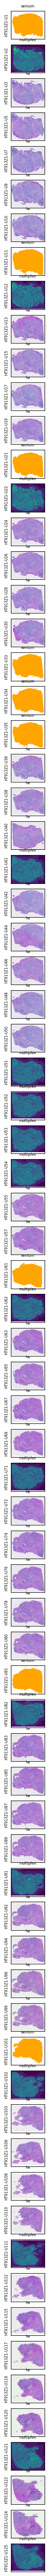

In [16]:
bigwarp.display_data_map(data_map, multiplex_channel=multiplex_channel, gamma=.5)

In [12]:
output_dir = os.path.join(reg_dir, 'unregistered_tifs') # where to write un-registered images to use with bigwarp
Path(output_dir).mkdir(parents=True, exist_ok=True)
output_dir

'/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT913Z1/registration/unregistered_tifs'

In [13]:
# image saving for each data type

def write_st(filepath, output_filepath, dtype, scale=.1):
    if dtype == 'visium':
        adata = visium.adata_from_visium(filepath)
    elif dtype == 'xenium':
        adata = xenium.adata_from_xenium(filepath)
    elif dtype == 'cosmx':
        adata = cosmx.adata_from_cosmx(filepath)
    else:
        raise RuntimeError(f'{dtype} not valid st data type')

    image_data = next(iter(adata.uns['spatial'].values()))
    
    img = image_data['images']['hires'] # grab image
    
    # need to adjust scale by tissue_hires_scalef because spot/cell coordinates are at a different resolution than the image
    sf = scale / image_data['scalefactors']['tissue_hires_scalef']
    
#     dim_order = 'h w' if dtype in ['xenium', 'cosmx'] else 'h w c'
    dim_order = 'h w' if len(img.shape) == 2 else 'h w c'
    img = utils.rescale(img, scale=sf, dim_order=dim_order, target_dtype=np.uint8) # scale image    
    
    tifffile.imwrite(output_filepath, img, compression='LZW') # write scaled H&E


def write_multiplex(filepath, output_filepath, channel='DAPI', scale=.1):
    # extract OME-TIF
    channel_to_img = multiplex.extract_ome_tiff(
        filepath, channels=[channel], scale=scale
    )
    
    # conversion to uint8
    img = channel_to_img[channel]
    if img.dtype != np.uint8:
        img = img.astype(np.float32)
        img /= img.max() # just use max intensity bc not sure what data type range we'll be dealing with
        img *= 255.
        img = img.astype(np.uint8)
        
    print(img.shape)
    tifffile.imwrite(output_filepath, img, compression='LZW')
    

def write_he(filepath, output_filepath, scale=.1):
    img = he.read_he(filepath, scale=scale)
    
    # lin et al has channel dim first
    if img.shape[0] == 3:
        img = rearrange(img, 'c h w -> h w c')

    tifffile.imwrite(output_filepath, img, compression='LZW')

In [14]:
for idx, item in enumerate(data_map['sections']):
    sid = item['sid']
    mapping = item['data'][0] # use first data type for registration by default
    dtype, filepath = mapping['dtype'], mapping['filepath']
    print(sid, dtype)

    output_filepath = os.path.join(output_dir, f's{idx}_{sid}.tif')

    scale = dtype_to_scale.get(dtype, default_scale)
    if utils.parse_dtype(dtype) in ['visium', 'cosmx', 'xenium']:
        write_st(filepath, output_filepath, dtype, scale=scale)
    elif utils.parse_dtype(dtype) == 'multiplex':
        write_multiplex(filepath, output_filepath, channel=multiplex_channel, scale=scale)
    elif utils.parse_dtype(dtype) == 'he':
        write_he(filepath, output_filepath, scale=scale)
    else:
        raise RuntimeError(f'{dtype} is not a valid data type identifier')

HT913Z1-U1 xenium


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
<tifffile.TiffFile 'morphology_focus_0000.ome.tif'> OME series cannot read multi-file pyramids


HT913Z1-U2 multiplex
(2698, 3390)
HT913Z1-U3 he
HT913Z1-U5 he
HT913Z1-U7 he
HT913Z1-U9 he
HT913Z1-U10 he
HT913Z1-U11 xenium


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
<tifffile.TiffFile 'morphology_focus_0000.ome.tif'> OME series cannot read multi-file pyramids


HT913Z1-U12 multiplex
(2698, 3310)
HT913Z1-U13 he
HT913Z1-U15 he
HT913Z1-U17 he
HT913Z1-U19 he
HT913Z1-U21 xenium


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
<tifffile.TiffFile 'morphology_focus_0000.ome.tif'> OME series cannot read multi-file pyramids


HT913Z1-U22 multiplex
(2735, 3272)
HT913Z1-U24 he
HT913Z1-U26 he
HT913Z1-U28 he
HT913Z1-U30 he
HT913Z1-U33 xenium


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
<tifffile.TiffFile 'morphology_focus_0000.ome.tif'> OME series cannot read multi-file pyramids


HT913Z1-U34 xenium


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
<tifffile.TiffFile 'morphology_focus_0000.ome.tif'> OME series cannot read multi-file pyramids


HT913Z1-U35 xenium


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
<tifffile.TiffFile 'morphology_focus_0000.ome.tif'> OME series cannot read multi-file pyramids


HT913Z1-U36 he
HT913Z1-U38 he
HT913Z1-U40 he
HT913Z1-U41 multiplex
(2710, 3235)
HT913Z1-U42 he
HT913Z1-U44 he
HT913Z1-U46 he
HT913Z1-U48 he
HT913Z1-U50 he
HT913Z1-U51 multiplex
(2664, 3265)
HT913Z1-U52 multiplex
(2546, 3336)
HT913Z1-U53 multiplex
(2532, 3312)
HT913Z1-U54 multiplex
(2617, 3265)
HT913Z1-U55 he
HT913Z1-U57 he
HT913Z1-U61 xenium


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
<tifffile.TiffFile 'morphology_focus_0000.ome.tif'> OME series cannot read multi-file pyramids


HT913Z1-U82 multiplex
(2423, 3133)
HT913Z1-U83 he
HT913Z1-U85 he
HT913Z1-U87 he
HT913Z1-U89 he
HT913Z1-U91 multiplex
(2364, 3005)
HT913Z1-U92 he
HT913Z1-U94 he
HT913Z1-U96 he
HT913Z1-U99 he
HT913Z1-U101 xenium


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
<tifffile.TiffFile 'morphology_focus_0000.ome.tif'> OME series cannot read multi-file pyramids


HT913Z1-U102 multiplex
(2264, 2817)
HT913Z1-U103 he
HT913Z1-U106 he
HT913Z1-U108 he
HT913Z1-U110 he
HT913Z1-U111 multiplex
(2161, 2756)
HT913Z1-U112 he
HT913Z1-U115 he
HT913Z1-U117 he
HT913Z1-U119 he
HT913Z1-U120 he
HT913Z1-U121 multiplex
(1875, 2233)
HT913Z1-U122 he
HT913Z1-U124 he
HT913Z1-U125 multiplex
(1875, 2377)


In [15]:
sorted(utils.listfiles(output_dir))

['/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT913Z1/registration/unregistered_tifs/s0_HT913Z1-U1.tif',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT913Z1/registration/unregistered_tifs/s10_HT913Z1-U15.tif',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT913Z1/registration/unregistered_tifs/s11_HT913Z1-U17.tif',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT913Z1/registration/unregistered_tifs/s12_HT913Z1-U19.tif',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT913Z1/registration/unregistered_tifs/s13_HT913Z1-U21.tif',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT913Z1/registration/unregistered_tifs/s14_HT913Z1-U22.tif',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT913Z1/registration/unregistered_tifs/s15_HT913Z1-U24.tif',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT913Z1

# registration (one-shot)

## post bigwarp registration

In [9]:
registered_dir = os.path.join(project_dir, case, 'registered') # this is where we will put our registered data for each section
Path(registered_dir).mkdir(parents=True, exist_ok=True)

In [10]:
fps = sorted(utils.listfiles(reg_dir, regex=r'ddf.tif$'))
fps

['/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT448C1-Th1K1Fp1/registration/s1_HT448C1-Th1K1Fp1-U2_ddf.tif',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT448C1-Th1K1Fp1/registration/s2_HT448C1-Th1K1Fp1-U13_ddf.tif',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT448C1-Th1K1Fp1/registration/s3_HT448C1-Th1K1Fp1-U14_ddf.tif']

In [11]:
target_sid = data_map['target_sid']

sid_to_ddf = {}

for idx, item in enumerate(data_map['sections']):
    sid = item['sid']
    mapping = item['data'][0]
    dtype, filepath = mapping['dtype'], mapping['filepath']
    scale = dtype_to_scale.get(dtype, default_scale)
    
    if sid != target_sid: # initial registration target section will not have ddf
        print(sid)
        ddf_fp = os.path.join(reg_dir, f's{idx}_{sid}_ddf.tif')

        assert os.path.exists(ddf_fp), f'Expected a warp field file at {ddf_fp}, but no file was found.'
        ddf = bigwarp.read_bigwarp_warp_field(ddf_fp, scale) # ddfs are (c h w)
        sid_to_ddf[sid] = ddf

sid_to_ddf.keys()

HT448C1-Th1K1Fp1-U2
HT448C1-Th1K1Fp1-U13
HT448C1-Th1K1Fp1-U14


dict_keys(['HT448C1-Th1K1Fp1-U2', 'HT448C1-Th1K1Fp1-U13', 'HT448C1-Th1K1Fp1-U14'])

In [12]:
registered_data_map = copy.deepcopy(data_map)

res = data_map['resolution']

for idx, item in enumerate(data_map['sections']):
    sid = item['sid']
    for m_idx, mapping in enumerate(item['data']):
        dtype, fp = mapping['dtype'], mapping['filepath']
        print(sid, dtype, fp)
        
        dtype_root = utils.parse_dtype(dtype)
        section_id = f's{idx}_{sid}'
        ddf = sid_to_ddf.get(sid)
        
        if dtype_root == 'he':
            img = he.read_he(fp)
            if img.shape[-1] == 3:
                img = rearrange(img, 'h w c -> c h w') # channel dim must be first
            if ddf is not None:
                img = bigwarp.register_he(img, ddf)
            output_filepath = os.path.join(registered_dir, f'{section_id}_{dtype}.tif')
            multiplex.write_basic_ome_tiff(
                output_filepath,
                img, ['red', 'green', 'blue'], microns_per_pixel=res
            )
                
        elif dtype_root == 'visium':
            adata = visium.adata_from_visium(fp)

            if ddf is not None:
                adata = bigwarp.register_visium(
                    adata, ddf, resolution=res
                )
            output_filepath = os.path.join(registered_dir, f'{section_id}_{dtype}.h5ad')
            adata.write_h5ad(output_filepath)
            
        elif dtype_root == 'xenium':
            # do morpholology image
            path = Path(fp)
            focus_dir = path / 'morphology_focus'
            if focus_dir.exists():
                names = sorted([name for name in os.listdir(focus_dir) if '.tif' in name])
                if names:
                    morph_fp = focus_dir / names[0]
            elif (path / 'morphology_focus.ome.tif').exists():
                morph_fp = path / 'morphology_focus.ome.tif'
            else:
                morph_fp = path / 'morphology.ome.tif'
            assert morph_fp.exists(), f'No morphology file found: {morph_fp}'

            channels, data = multiplex.extract_ome_tiff(morph_fp, as_dict=False)
            focus_res = multiplex.pixels_per_micron(morph_fp) # is actually microns per pixel
            # needs to be scaled to same res as ddf to work
            data = utils.rescale(data, scale=focus_res / res, dim_order='c h w', target_dtype=data.dtype)
            if ddf is not None:
                data = bigwarp.register_multiplex(data, ddf)
            output_filepath = os.path.join(registered_dir, f'{section_id}_{dtype}_morphologyfocus.ome.tiff')
            multiplex.write_basic_ome_tiff(
                output_filepath,
                data, channels, microns_per_pixel=res
            )

            # check for transcripts
            transcripts_fp = path / 'transcripts.parquet'
            assert transcripts_fp.exists(), f'transcripts not found: {transcripts_fp}'
            transcripts = pd.read_parquet(transcripts_fp)
            if ddf is not None:
                print('pre transcripts', transcripts.shape[0])
                warped, mask = bigwarp.warp_pts_fast(transcripts[['y_location', 'x_location']].values, ddf)
                transcripts = transcripts[mask]
                transcripts['y_location'] = warped[:, 0]
                transcripts['x_location'] = warped[:, 1]
                print('post transcripts', transcripts.shape[0])
            output_filepath = os.path.join(registered_dir, f'{section_id}_{dtype}_transcripts.parquet')
            transcripts.to_parquet(output_filepath)
            
            # do cells
            adata = xenium.adata_from_xenium(fp)
            if ddf is not None:
                adata = bigwarp.register_xenium(
                    adata, ddf, resolution=res
                )
            output_filepath = os.path.join(registered_dir, f'{section_id}_{dtype}.h5ad')
            adata.write_h5ad(output_filepath)
            
        elif dtype_root == 'cosmx':
            adata = cosmx.adata_from_cosmx(fp)
            if ddf is not None:
                0
                print(adata.shape)
            output_filepath = os.path.join(registered_dir, f'{section_id}_{dtype}.h5ad')
            adata.write_h5ad(output_filepath)
            
        elif dtype_root == 'multiplex':
            channels, data = multiplex.extract_ome_tiff(fp, as_dict=False)
            if ddf is not None:
                data = bigwarp.register_multiplex(data, ddf)
            output_filepath = os.path.join(registered_dir, f'{section_id}_{dtype}.ome.tiff')
            multiplex.write_basic_ome_tiff(
                output_filepath,
                data, channels, microns_per_pixel=res
            )
        
        registered_data_map['sections'][idx]['data'][m_idx]['filepath'] = output_filepath

HT448C1-Th1K1Fp1-U1 visium /diskmnt/Datasets/Spatial_Transcriptomics/outputs_FFPE/Human/HT448C1/Th1K1/HT448C1-Th1K1Fp1U1Bp1/outs


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


HT448C1-Th1K1Fp1-U1 he /diskmnt/Datasets/Spatial_Transcriptomics/images/all/C1_HT448C1-Th1K1Fp1U1.tif
HT448C1-Th1K1Fp1-U2 multiplex /diskmnt/primary/CODEX/HTAN/041323_CRC_HT488C1-Th1K1Fp1-U2/HT488C1-Th1K1Fp1__20230413.ome.tiff
HT448C1-Th1K1Fp1-U13 visium /diskmnt/Datasets/Spatial_Transcriptomics/outputs_FFPE/Human/HT448C1/Th1K1/HT448C1-Th1K1Fp1U13Bp1/outs


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future versio

HT448C1-Th1K1Fp1-U13 he /diskmnt/Datasets/Spatial_Transcriptomics/images/all/D1_HT448C1-Th1K1Fp1U13.tif
HT448C1-Th1K1Fp1-U14 multiplex /diskmnt/primary/CODEX/HTAN/041823_CRC_HT488C1-Th1K1Fp1-U14/HT488C1-Th1K1Fp1-U14__20230419.ome.tiff


HT448C1-Th1K1Fp1-U1 visium
HT448C1-Th1K1Fp1-U1 he
HT448C1-Th1K1Fp1-U2 multiplex
HT448C1-Th1K1Fp1-U13 visium
HT448C1-Th1K1Fp1-U13 he
HT448C1-Th1K1Fp1-U14 multiplex


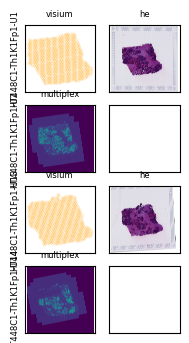

In [13]:
bigwarp.display_data_map(registered_data_map, multiplex_channel=multiplex_channel, gamma=.5)

## save registration metadata

In [14]:
yaml.safe_dump(registered_data_map, open(os.path.join(registered_dir, 'metadata.yaml'), 'w'))

In [15]:
# just viewing
yaml.safe_dump(registered_data_map, sys.stdout)

resolution: 0.3646048129944151
sections:
- data:
  - dtype: visium
    filepath: /diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT448C1-Th1K1Fp1/registered/s0_HT448C1-Th1K1Fp1-U1_visium.h5ad
  - dtype: he
    filepath: /diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT448C1-Th1K1Fp1/registered/s0_HT448C1-Th1K1Fp1-U1_he.tif
  position: 0
  sid: HT448C1-Th1K1Fp1-U1
- data:
  - dtype: multiplex
    filepath: /diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT448C1-Th1K1Fp1/registered/s1_HT448C1-Th1K1Fp1-U2_multiplex.ome.tiff
  position: 5
  sid: HT448C1-Th1K1Fp1-U2
- data:
  - dtype: visium
    filepath: /diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT448C1-Th1K1Fp1/registered/s2_HT448C1-Th1K1Fp1-U13_visium.h5ad
  - dtype: he
    filepath: /diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT448C1-Th1K1Fp1/registered/s2_HT448C1-Th1K1Fp1-U13_he.tif
  position: 60
  sid: HT448C1-Th1K1Fp1-

In [33]:
# registered_data_map = yaml.safe_load(open(
#     '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT397B1/registered/metadata.yaml'
# ))

# bigwarp.display_data_map(registered_data_map, multiplex_channel='DAPI', gamma=.5)

###### bugfix: fix visium registration issue

some previously registered samples had incorrect resolutions, fixing here

In [11]:
fps = sorted(utils.listfiles(project_dir, regex=r'registered/metadata.yaml'))
fps = [fp for fp in fps
      if fp.split('/')[-4] not in ['kidney', 'lightsheet']]
fps

['/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/C3L-00970/registered/metadata.yaml',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/C3L-00982/registered/metadata.yaml',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/C3L-01287/registered/metadata.yaml',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/C3L-02551/registered/metadata.yaml',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT206B1/registered/metadata.yaml',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT225C1/registered/metadata.yaml',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT268B1/registered/metadata.yaml',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT339B2-H1/registered/metadata.yaml',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT397B1/registered/metadata.yaml',
 '/diskmnt/Projects/Users/estorrs/m

In [110]:
# rewrite visium target res
for fp in fps:
    config = yaml.safe_load(open(fp))
    if config is not None:
        target_sid = config['target_sid']
        visium_fp = None
        for entry in config['sections']:
            if entry['sid'] == target_sid:
                for mapping in entry['data']:
                    if mapping['dtype'] == 'visium':
                        visium_fp = mapping['filepath']

        if visium_fp is not None:
            res = visium.pixels_per_micron(visium.adata_from_visium(visium_fp))
            print(target_sid, res)
    else:
        print(fp)
        


HT225C1-U2 0.340630523443302
HT268B1-U2 0.35022286517247164
HT339B2-H1-U1 0.35026268395892945
HT397B1-U1 0.36435700315543124
HT413C1-K2-U1 0.35484531065226865
HT448C1-Th1K1Fp1-U1 0.3646048129944151
HT553P1-H2-U1 0.3502120209285467
HT565B1-H2-U1 0.3414196499351769


#### adjust resolution for visium

blocks with visium sections as the target section do not have a resolution of 1. for consistency here these blocks are rescaled to have a resolution of 1 micron per pixel to match blocks with xenium as the target section

In [16]:
fps = sorted(utils.listfiles(project_dir, regex=r'registered/metadata.yaml'))
fps = [fp for fp in fps
      if fp.split('/')[-4] not in ['kidney', 'lightsheet']]
fps

['/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/C3L-00970/registered/metadata.yaml',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/C3L-00982/registered/metadata.yaml',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/C3L-01287/registered/metadata.yaml',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/C3L-02551/registered/metadata.yaml',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT206B1/registered/metadata.yaml',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT225C1/registered/metadata.yaml',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT268B1/registered/metadata.yaml',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT339B2-H1/registered/metadata.yaml',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT397B1/registered/metadata.yaml',
 '/diskmnt/Projects/Users/estorrs/m

In [17]:
# rewrite visium target res
configs = []
for fp in fps:
    config = yaml.safe_load(open(fp))
    if config is not None:
        target_sid = config['target_sid']
        for entry in config['sections']:
            if entry['sid'] == target_sid:
                for mapping in entry['data']:
                    if mapping['dtype'] == 'visium':
                        configs.append(fp)

        
configs

['/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT225C1/registered/metadata.yaml',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT268B1/registered/metadata.yaml',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT339B2-H1/registered/metadata.yaml',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT397B1/registered/metadata.yaml',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT413C1-K2/registered/metadata.yaml',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT448C1-Th1K1Fp1/registered/metadata.yaml',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT553P1-H2/registered/metadata.yaml',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT565B1-H2/registered/metadata.yaml']

In [25]:
res = 1.
for config_fp in configs:
    config = yaml.safe_load(open(config_fp))
    new_config = copy.deepcopy(config)
    initial_res = config['resolution']
    scaler = initial_res / res
    
    for idx, item in enumerate(config['sections']):
        sid = item['sid']
        for m_idx, mapping in enumerate(item['data']):
            dtype, fp = mapping['dtype'], mapping['filepath']
            print(sid, dtype, fp)

            dtype_root = utils.parse_dtype(dtype)
            section_id = f's{idx}_{sid}'

            if dtype_root == 'he':
                img = he.read_he(fp)
                if img.shape[-1] == 3:
                    img = rearrange(img, 'h w c -> c h w') # channel dim murescalebe first
                img = utils.rescale(img, scale=scaler, dim_order='c h w', target_dtype=img.dtype)
#                 output_filepath = os.path.join(registered_dir, f'{section_id}_{dtype}_scaled.tif')
                output_filepath = fp.replace(f'{section_id}_{dtype}', f'{section_id}_{dtype}_scaled')
                multiplex.write_basic_ome_tiff(
                    output_filepath,
                    img, ['red', 'green', 'blue'], microns_per_pixel=res
                )

            elif dtype_root == 'visium':
                adata = visium.adata_from_visium(fp)

                adata = visium.scale_adata(adata, scaler)
                
#                 output_filepath = os.path.join(registered_dir, f'{section_id}_{dtype}_scaled.h5ad')
                output_filepath = fp.replace(f'{section_id}_{dtype}', f'{section_id}_{dtype}_scaled')
                adata.write_h5ad(output_filepath)

            elif dtype_root == 'xenium':
                # for simplicity only doing it for cells
                # also pretty sure this will never get invoked
                adata = xenium.adata_from_xenium(fp)
                adata = visium.scale_adata(adata, scaler)
#                 output_filepath = os.path.join(registered_dir, f'{section_id}_{dtype}_scaled.h5ad')
                output_filepath = fp.replace(f'{section_id}_{dtype}', f'{section_id}_{dtype}_scaled')
                adata.write_h5ad(output_filepath)

            elif dtype_root == 'cosmx':
                # for simplicity only doing it for cells
                # also pretty sure this will never get invoked
                adata = cosmx.adata_from_cosmx(fp)
                adata = visium.scale_adata(adata, scaler)
#                 output_filepath = os.path.join(registered_dir, f'{section_id}_{dtype}_scaled.h5ad')
                output_filepath = fp.replace(f'{section_id}_{dtype}', f'{section_id}_{dtype}_scaled')
                adata.write_h5ad(output_filepath)

            elif dtype_root == 'multiplex':
                channels, data = multiplex.extract_ome_tiff(fp, as_dict=False)
                data = utils.rescale(data, scale=scaler, dim_order='c h w', target_dtype=data.dtype)
#                 output_filepath = os.path.join(registered_dir, f'{section_id}_{dtype}_scaled.ome.tiff')
                output_filepath = fp.replace(f'{section_id}_{dtype}', f'{section_id}_{dtype}_scaled')
                multiplex.write_basic_ome_tiff(
                    output_filepath,
                    data, channels, microns_per_pixel=res
                )

            new_config['sections'][idx]['data'][m_idx]['filepath'] = output_filepath
    new_config['resolution'] = res
#     print(yaml.safe_dump(new_config, sys.stdout))
#     yaml.safe_dump(new_config, open(os.path.join(registered_dir, 'metadata.yaml'), 'w'))
    yaml.safe_dump(new_config, open(config_fp, 'w'))
#     break

HT268B1-U2 visium /diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT268B1/registered/s0_HT268B1-U2_visium.h5ad
HT268B1-U2 he /diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT268B1/registered/s0_HT268B1-U2_he.tif
HT268B1-U12 visium /diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT268B1/registered/s1_HT268B1-U12_visium.h5ad
HT268B1-U12 he /diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT268B1/registered/s1_HT268B1-U12_he.tif
HT268B1-U22 visium /diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT268B1/registered/s2_HT268B1-U22_visium.h5ad
HT268B1-U22 he /diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT268B1/registered/s2_HT268B1-U22_he.tif
HT268B1-U32 visium /diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT268B1/registered/s3_HT268B1-U32_visium.h5ad
HT268B1-U32 he /diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT268B1/r

In [27]:
adata = visium.adata_from_visium(
    '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT565B1-H2/registered/s0_HT565B1-H2-U1_visium_scaled.h5ad'
)
adata

AnnData object with n_obs × n_vars = 3352 × 17943
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'ppm', 'spatial'
    obsm: 'spatial'

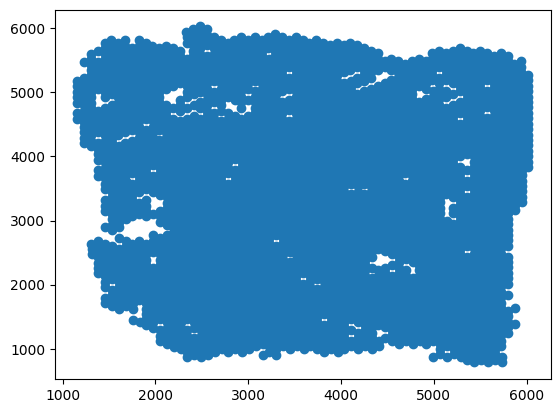

In [28]:
import matplotlib.pyplot as plt
plt.scatter(adata.obsm['spatial'][:, 0], adata.obsm['spatial'][:, 1])

In [29]:
x = tifffile.imread('/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT565B1-H2/registered/s1_HT565B1-H2-U2_multiplex_scaled.ome.tiff')
x.shape

(33, 6792, 6693)

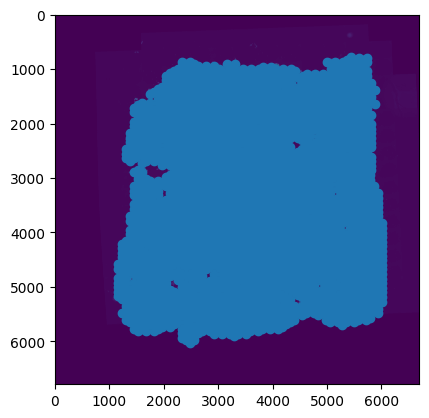

In [30]:
plt.imshow(rearrange(x, 'c h w -> h w c'))
plt.scatter(adata.obsm['spatial'][:, 0], adata.obsm['spatial'][:, 1])

###### add visium HD to metadata

# registration (parts)

#### registration of parts

In [15]:
registered_dir = os.path.join(project_dir, case, 'registered') # this is where we will put our registered data for each section
Path(registered_dir).mkdir(parents=True, exist_ok=True)

In [16]:
sid_to_ddfs = {}
for idx, item in enumerate(data_map['sections']):
    sid = item['sid']
    mapping = item['data'][0]
    dtype, filepath = mapping['dtype'], mapping['filepath']
    scale = dtype_to_scale.get(dtype, default_scale)
    
    p = sid_to_part[sid]
    
    ddfs = []
    
    t_sid = target_sids[p]
    if t_sid != sid:
        # add sample specific
        ddf_fp = os.path.join(reg_dir, p, f's{idx}_{sid}_ddf.tif')
        assert os.path.exists(ddf_fp), f'expected {ddf_fp} to exist'
        ddfs.append(ddf_fp)
    
    part_ddfs = []
    for part in parts:        
        if part != parts[0]:
            ddf_fp = os.path.join(reg_dir, 'final', f'{part}_ddf.tif')
            assert os.path.exists(ddf_fp), f'expected {ddf_fp} to exist'
            part_ddfs.append(ddf_fp)
        if part == p:
            break
    part_ddfs = part_ddfs[::-1]
    
    ddfs += part_ddfs
    
    sid_to_ddfs[sid] = ddfs
    
sid_to_ddfs
    
    

{'WD-76845-U1': ['/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/WD-76845/registration/p1/s0_WD-76845-U1_ddf.tif'],
 'WD-76845-U2': [],
 'WD-76845-U6': ['/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/WD-76845/registration/p1/s2_WD-76845-U6_ddf.tif'],
 'WD-76845-U7': ['/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/WD-76845/registration/p1/s3_WD-76845-U7_ddf.tif'],
 'WD-76845-U13': ['/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/WD-76845/registration/p1/s4_WD-76845-U13_ddf.tif'],
 'WD-76845-U14': ['/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/WD-76845/registration/p1/s5_WD-76845-U14_ddf.tif'],
 'WD-76845-U19': ['/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/WD-76845/registration/p1/s6_WD-76845-U19_ddf.tif'],
 'WD-76845-U20': ['/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/WD-76845/registration/p1/s7_WD-76845-U20_ddf.tif'],
 'WD-7

In [17]:
registered_data_map = copy.deepcopy(data_map)
res = registered_data_map['resolution']

for idx, item in enumerate(data_map['sections']):
    sid = item['sid']
    for m_idx, mapping in enumerate(item['data']):
        dtype, fp = mapping['dtype'], mapping['filepath']
        scale = dtype_to_scale.get(dtype, default_scale)
        print(sid, dtype, fp)
        
        dtype_root = utils.parse_dtype(dtype)
        section_id = f's{idx}_{sid}'
        
        ddfs = sid_to_ddfs[sid]
        
        if not len(ddfs):
            ddfs = [None]
            
        
        img, adata = None, None
        for i, ddf_fp in enumerate(ddfs):
            
            if ddf_fp is not None:
                ddf = bigwarp.read_bigwarp_warp_field(ddf_fp, scale) # ddfs are (c h w)
            else:
                ddf = None
                
            print(sid, i, ddf.shape if ddf is not None else ddf, ddf_fp)
            
            if dtype_root == 'he':
                if i == 0:
                    img = he.read_he(fp)
                
                # expects c h w
                if img.shape[-1] == 3:
                    img = rearrange(img, 'h w c -> c h w')

                if ddf is not None:
                    img = bigwarp.register_he(img, ddf)
                print(img.shape)
                
                if len(ddfs) - 1 == i:
                    output_filepath = os.path.join(registered_dir, f'{section_id}_{dtype}.tif')
                    tifffile.imwrite(
                        output_filepath,
                        data=rearrange(img, 'c h w -> h w c'),
                        resolution=(res, res),
                        compression='LZW',
                        bigtiff=True,
                        metadata={
                            'axes': 'YXC',
                            'unit': 'um', # assumes microns as unit
                        }
                    )
            elif dtype_root == 'visium':
                if i == 0:
                    adata = visium.adata_from_visium(fp)

                if ddf is not None:
                    adata = bigwarp.register_visium(
                        adata, ddf, resolution=res
                    )
                
                if len(ddfs) - 1 == i:
                    output_filepath = os.path.join(registered_dir, f'{section_id}_{dtype}.h5ad')
                    adata.write_h5ad(output_filepath)
            elif dtype_root == 'xenium':
                if i == 0:
                    adata = xenium.adata_from_xenium(fp)
                if ddf is not None:
                    adata = bigwarp.register_xenium(
                        adata, ddf, resolution=res
                    )
                if len(ddfs) - 1 == i:
                    output_filepath = os.path.join(registered_dir, f'{section_id}_{dtype}.h5ad')
                    adata.write_h5ad(output_filepath)
            elif dtype_root == 'cosmx':
                if i == 0:
                    adata = cosmx.adata_from_cosmx(fp)
                if ddf is not None:
                    adata = bigwarp.register_cosmx(
                        adata, ddf, resolution=res
                    )
                if len(ddfs) - 1 == i:
                    output_filepath = os.path.join(registered_dir, f'{section_id}_{dtype}.h5ad')
                    adata.write_h5ad(output_filepath)
            elif dtype_root == 'multiplex':
                if i == 0:
                    channels, data = multiplex.extract_ome_tiff(fp, as_dict=False)
                if ddf is not None:
                    data = bigwarp.register_multiplex(data, ddf)
                print(data.shape)
                if len(ddfs) - 1 == i:
                    output_filepath = os.path.join(registered_dir, f'{section_id}_{dtype}.ome.tiff')
                    multiplex.write_basic_ome_tiff(
                        output_filepath,
                        data, channels, pix_per_micron=res
                    )
                    
        registered_data_map['sections'][idx]['data'][m_idx]['filepath'] = output_filepath
            

WD-76845-U1 he /diskmnt/Projects/Users/estorrs/mushroom/data/public/lin_et_al/WD-76845-001.ome.tif
WD-76845-U1 0 torch.Size([2, 28140, 29860]) /diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/WD-76845/registration/p1/s0_WD-76845-U1_ddf.tif
(3, 28140, 29860)
WD-76845-U2 multiplex /diskmnt/Projects/Users/estorrs/mushroom/data/public/lin_et_al/WD-76845-002.ome.tif
WD-76845-U2 0 None None
(40, 28158, 29877)
WD-76845-U6 he /diskmnt/Projects/Users/estorrs/mushroom/data/public/lin_et_al/WD-76845-006.ome.tif
WD-76845-U6 0 torch.Size([2, 28140, 29860]) /diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/WD-76845/registration/p1/s2_WD-76845-U6_ddf.tif
(3, 28140, 29860)
WD-76845-U7 multiplex /diskmnt/Projects/Users/estorrs/mushroom/data/public/lin_et_al/WD-76845-007.ome.tif
WD-76845-U7 0 torch.Size([2, 28140, 29860]) /diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/WD-76845/registration/p1/s3_WD-76845-U7_ddf.tif
(40, 28140, 29860)
WD-76845-

WD-76845-U54 1 torch.Size([2, 28140, 29860]) /diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/WD-76845/registration/final/p2_ddf.tif
(40, 28140, 29860)
WD-76845-U58 he /diskmnt/Projects/Users/estorrs/mushroom/data/public/lin_et_al/WD-76845-058.ome.tif
WD-76845-U58 0 torch.Size([2, 54280, 52380]) /diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/WD-76845/registration/p2/s25_WD-76845-U58_ddf.tif
(3, 54280, 52380)
WD-76845-U58 1 torch.Size([2, 28140, 29860]) /diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/WD-76845/registration/final/p2_ddf.tif
(3, 28140, 29860)
WD-76845-U59 multiplex /diskmnt/Projects/Users/estorrs/mushroom/data/public/lin_et_al/WD-76845-059.ome.tif
WD-76845-U59 0 torch.Size([2, 54280, 52380]) /diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/WD-76845/registration/p2/s26_WD-76845-U59_ddf.tif
(40, 54280, 52380)
WD-76845-U59 1 torch.Size([2, 28140, 29860]) /diskmnt/Projects/Users/estorrs/mushroom

(3, 28140, 29860)
WD-76845-U91 multiplex /diskmnt/Projects/Users/estorrs/mushroom/data/public/lin_et_al/WD-76845-091.ome.tif
WD-76845-U91 0 torch.Size([2, 25020, 26120]) /diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/WD-76845/registration/p3/s40_WD-76845-U91_ddf.tif
(40, 25020, 26120)
WD-76845-U91 1 torch.Size([2, 54280, 52380]) /diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/WD-76845/registration/final/p3_ddf.tif
(40, 54280, 52380)
WD-76845-U91 2 torch.Size([2, 28140, 29860]) /diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/WD-76845/registration/final/p2_ddf.tif
(40, 28140, 29860)
(3, 25020, 26120)
WD-76845-U96 1 torch.Size([2, 54280, 52380]) /diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/WD-76845/registration/final/p3_ddf.tif
(3, 54280, 52380)
WD-76845-U96 2 torch.Size([2, 28140, 29860]) /diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/WD-76845/registration/final/p2_ddf.tif
(3, 28

WD-76845-U1 he
WD-76845-U2 multiplex
WD-76845-U6 he
WD-76845-U7 multiplex
WD-76845-U13 he
WD-76845-U14 multiplex
WD-76845-U19 he
WD-76845-U20 multiplex
WD-76845-U24 he
WD-76845-U25 multiplex
WD-76845-U28 he
WD-76845-U29 multiplex
WD-76845-U33 he
WD-76845-U34 multiplex
WD-76845-U38 he
WD-76845-U39 multiplex
WD-76845-U43 he
WD-76845-U44 multiplex
WD-76845-U48 he
WD-76845-U49 multiplex
WD-76845-U50 multiplex
WD-76845-U51 multiplex
WD-76845-U52 multiplex
WD-76845-U53 he
WD-76845-U54 multiplex
WD-76845-U58 he
WD-76845-U59 multiplex
WD-76845-U63 he
WD-76845-U64 multiplex
WD-76845-U68 he
WD-76845-U69 multiplex
WD-76845-U73 he
WD-76845-U74 multiplex
WD-76845-U77 he
WD-76845-U78 multiplex
WD-76845-U83 he
WD-76845-U84 multiplex
WD-76845-U85 he
WD-76845-U86 multiplex
WD-76845-U90 he
WD-76845-U91 multiplex
WD-76845-U96 he
WD-76845-U97 multiplex
WD-76845-U101 he
WD-76845-U102 multiplex
WD-76845-U105 he
WD-76845-U106 multiplex


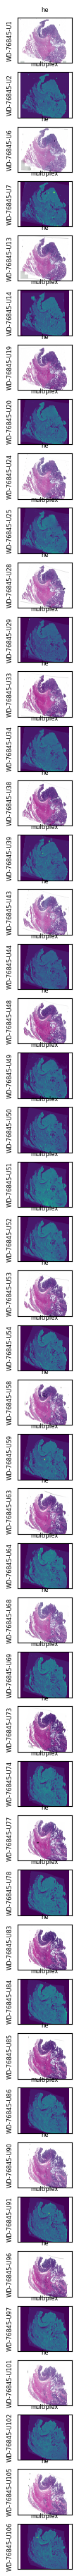

In [20]:
bigwarp.display_data_map(registered_data_map, multiplex_channel=multiplex_channel, gamma=.5)

In [21]:
yaml.safe_dump(registered_data_map, open(os.path.join(registered_dir, 'metadata.yaml'), 'w'))

In [22]:
# just viewing
yaml.safe_dump(registered_data_map, sys.stdout)

resolution: 0.6499999761581421
sections:
- data:
  - dtype: he
    filepath: /diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/WD-76845/registered/s0_WD-76845-U1_he.tif
  position: 5
  sid: WD-76845-U1
- data:
  - dtype: multiplex
    filepath: /diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/WD-76845/registered/s1_WD-76845-U2_multiplex.ome.tiff
  position: 10
  sid: WD-76845-U2
- data:
  - dtype: he
    filepath: /diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/WD-76845/registered/s2_WD-76845-U6_he.tif
  position: 30
  sid: WD-76845-U6
- data:
  - dtype: multiplex
    filepath: /diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/WD-76845/registered/s3_WD-76845-U7_multiplex.ome.tiff
  position: 35
  sid: WD-76845-U7
- data:
  - dtype: he
    filepath: /diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/WD-76845/registered/s4_WD-76845-U13_he.tif
  position: 65
  sid: WD-76845-U13
- data:
  - dty